This notebook gathers results from running top-pruning and generalized pruning nni-searches on the ds-datasets.

To benchmark against existing methods, we compare with the topologies discovered by a short run of Mr Bayes and match the data by the number of likelihood calculations and by approximate run-time. For run-time, scripts ran on the slurm cluster as jobs with exlcusive node access, with the calculations turned off for collecting the other statistics. 

In [11]:
%%javascript
 
// I dislike the default Jupyter notebook scrolling.
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down');

<IPython.core.display.Javascript object>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

In [13]:
# Load all data files into dataframes.
ds_datasets = [1, 3, 4, 5, 6, 7, 8]
mb_prior = {"uniform":"_output", "exponential":"_exp_output"}
search_type = {"top-pruning": "tp", "generalized-pruning": "gp"}
iter_count = 500

mb_avg_gen_run_time = {
    (1, "uniform"): 434/1000000,
    (1, "exponential"): 432/1000000,
    (3, "uniform"): 652/1000000,
    (3, "exponential"): 659/1000000,
    (4, "uniform"): 456/1000000,
    (4, "exponential"): 460/1000000,
    (5, "uniform"): 254/1000000,
    (5, "exponential"): 252/1000000,
    (6, "uniform"): 367/1000000,
    (6, "exponential"): 367/1000000,
    (7, "uniform"): 874/1000000,
    (7, "exponential"): 877/1000000,
    (8, "uniform"): 377/1000000,
    (8, "exponential"): 377/1000000
}

search_results_path = "data/ds{}/{}/ds{}.results.{}.{}.csv"
found_trees_stats_path = "data/ds{}/{}/ds{}.found-trees-dag-stats.{}.{}.csv"
short_mcmc_stats_path = "data/ds{}/{}/short_mcmc/mcmc_search_sdag_stats.csv"
search_time_path = search_results_path + ".time.csv"
mcmc_time_path = "data/ds{}/{}/short_mcmc/timing/mcmc_search_stats.csv"

posterior_edge_stats_df = pd.read_csv("data/posterior_edge_counts.csv")
posterior_edge_stats_dict = posterior_edge_stats_df.set_index(["ds", "prior"]).to_dict("index")
posterior_subsplit_stats_df = pd.read_csv("data/posterior_subsplit_counts.csv")
posterior_subsplit_stats_dict = posterior_subsplit_stats_df.set_index(["ds", "prior"]).to_dict("index")

ds_search_results_dataframes = {}
ds_short_mcmc_dataframes = {}
for ds in ds_datasets:
    for prior, prior_path in mb_prior.items():
        for search, search_path in search_type.items():
            results_path = search_results_path.format(
                ds, prior_path, ds, search_path, iter_count
            )
            results_df = pd.read_csv(results_path)
            results_df.drop_duplicates(subset="iter", keep="first", inplace=True)

            time_path = search_time_path.format(
                ds, prior_path, ds, search_path, iter_count
            )
            time_df = pd.read_csv(time_path)
            results_df = results_df.merge(time_df, on="iter")

            for posterior_type in ["credible", "posterior"]:
                extra_stats_path = found_trees_stats_path.format(
                    ds, prior_path, ds, search_path, posterior_type
                )
                extra_stats_df = pd.read_csv(extra_stats_path)
                column_rename_dict = {
                    column: f"{posterior_type}_sdag_{column}"
                    for column in ["tree_count", "node_count", "edge_count"]
                }
                extra_stats_df.rename(columns=column_rename_dict, inplace=True)
                results_df = results_df.merge(extra_stats_df, on="iter")                
            ds_search_results_dataframes[(ds, prior, search)] = results_df
        short_mcmc_path = short_mcmc_stats_path.format(ds,prior_path)
        short_mcmc_df = pd.read_csv(short_mcmc_path)
        ds_short_mcmc_dataframes[(ds, prior)] = short_mcmc_df
    
        time_mcmc_path = mcmc_time_path.format(ds, prior_path)
        time_mcmc_df = pd.read_csv(time_mcmc_path)
        time_mcmc_df["time"] = mb_avg_gen_run_time[(ds,prior)]*time_mcmc_df.mcmc_iters
        ds_short_mcmc_dataframes[(ds, prior, "time")] = time_mcmc_df        


In [14]:
def plot_search_results(
    ds, 
    prior, 
    search, 
    max_iter=None, 
    stop_at_max_posterior=True, 
    stop_at_credible=False
):
    """
    Create various plots for the cumulative density, topology count, edge count,
    and run-time for the specified nni-search and comparisons with Mr Bayes.

    Parameters:
        ds (int): The dataset number. This should be 1, 3, 4, 5, 6, 7, or 8.
        prior (str): The branch length prior for the Mr. Bayes posterior. This should be 
        "uniform" or "exponential".
        search (str): The search type. This should be "top-pruning" or 
            "generalized-pruning".
        max_iter (int): Optional cut-off for the search iteration.
        stop_at_max_posterior (bool): Optionally cut-off the search iteration to that of 
            the last found topology in the Mr. Bayes credible set. 
        stop_at_credible (bool): Optionally cut-off the search iteration to the of the 
            last found found topology in the Mr. Bayes posterior.

    """
    search_df = ds_search_results_dataframes[(ds, prior, search)]      
    mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
    mcmc_time_df = ds_short_mcmc_dataframes[(ds, prior, "time")]
    if max_iter is not None:
        search_df = search_df[search_df.iter <= max_iter]
    if stop_at_max_posterior:
        last_posterior_tree_iteration = search_df.tree_pp.argmax()
        search_df = search_df[search_df.iter <= last_posterior_tree_iteration]
    if stop_at_credible:
        last_credible_tree_iteration = search_df.cred_tree_count.argmax()
        search_df = search_df[search_df.iter <= last_posterior_tree_iteration]

    dag_label = f"{search} sDAG"
    cred_subdag_label = "sub-sDAG spanned by found credible trees"
    posterior_subdag_label = "sub-sDAG spanned by found posterior trees"
    iter_label = f"{search} iteration"
    fig_title = f"{search} search of DS{ds} Mr. Bayes posterior w/ {prior} branch length prior"
    
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6)
    fig.set_figwidth(2*fig.get_figwidth())
    fig.set_figheight(7*fig.get_figheight())
    
    options = {"s":10, "alpha":0.75}
    
    ax1.scatter(search_df.iter, search_df.tree_pp, **options)
    ax1.set_xlabel(iter_label)
    ax1.set_ylabel("cumulative density of trees\n in search sDAG")

    ax2.scatter(search_df.llhs_computed, search_df.tree_pp, label=dag_label, **options)
    ax2.scatter(mcmc_df.mcmc_iters, mcmc_df.total_pp, label="short run of Mr. Bayes", **options)
    ax2.scatter(mcmc_df.mcmc_iters, mcmc_df.sdag_total_pp, 
                label="sdag spanned by short run of Mr. Bayes", **options)
    ax2.set_xlabel("tree log-likelihood calculations")
    ax2.set_ylabel("cumulative density of trees")
    ax2.legend()
        
    ax3.scatter(search_df.iter, search_df.edge_count, label=dag_label, **options)
    ax3.scatter(search_df.iter, search_df.credible_sdag_edge_count, label=cred_subdag_label, **options)
    ax3.scatter(search_df.iter, search_df.posterior_sdag_edge_count, label=posterior_subdag_label, **options)
    ax3.set_xlabel(iter_label)
    ax3.set_ylabel("edges in sDAG")
    ax3.legend()
    
    ax4.scatter(search_df.iter, search_df.tree_count.apply(int), label=dag_label, **options)
    ax4.scatter(search_df.iter, search_df.credible_sdag_tree_count, 
        label=cred_subdag_label, **options)
    ax4.scatter(search_df.iter, search_df.posterior_sdag_tree_count, 
        label=posterior_subdag_label, **options)
    ax4.set_xlabel(iter_label)
    ax4.set_ylabel("topologies in sDAG")
    ax4.legend()
    ax4.ticklabel_format(useOffset=False, style="plain")
    
    ax5.scatter(search_df.iter, search_df.time, **options)
    ax5.set_xlabel(iter_label)
    ax5.set_ylabel("approximate run-time (seconds)")

    ax6.scatter(search_df.time, search_df.tree_pp, label=dag_label, **options)
    ax6.scatter(mcmc_time_df.time, mcmc_time_df.total_pp, label="short run of Mr. Bayes", **options)
    ax6.set_xlabel("approximate run-time (seconds)")
    ax6.set_ylabel("cumulative density of trees")
    ax6.legend()

    
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle(fig_title, va="bottom",y=0.9)
    fig.set_facecolor("white")
    
    plt.show()

In [15]:
def plot_timing_results(
    ds, 
    prior, 
    search, 
    max_iter=None, 
    stop_at_max_posterior=True, 
    stop_at_credible=False
):
    """
    Create plots for the run-time and cumulative density for the specified nni-search and 
    comparisons with Mr Bayes. This is a subset of the plots generated by plot_search_results.

    Parameters:
        ds (int): The dataset number. This should be 1, 3, 4, 5, 6, 7, or 8.
        prior (str): The branch length prior for the Mr. Bayes posterior. This should be 
        "uniform" or "exponential".
        search (str): The search type. This should be "top-pruning" or 
            "generalized-pruning".
        max_iter (int): Optional cut-off for the search iteration.
        stop_at_max_posterior (bool): Optionally cut-off the search iteration to that of 
            the last found topology in the Mr. Bayes credible set. 
        stop_at_credible (bool): Optionally cut-off the search iteration to the of the 
            last found found topology in the Mr. Bayes posterior.

    """
    search_df = ds_search_results_dataframes[(ds, prior, search)]      
    mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
    mcmc_time_df = ds_short_mcmc_dataframes[(ds, prior, "time")]
    if max_iter is not None:
        search_df = search_df[search_df.iter <= max_iter]
    if stop_at_max_posterior:
        last_posterior_tree_iteration = search_df.tree_pp.argmax()
        search_df = search_df[search_df.iter <= last_posterior_tree_iteration]
    if stop_at_credible:
        last_credible_tree_iteration = search_df.cred_tree_count.argmax()
        search_df = search_df[search_df.iter <= last_posterior_tree_iteration]

    dag_label = f"{search} sDAG"
    iter_label = f"{search} iteration"
    fig_title = f"{search} search of DS{ds} Mr. Bayes posterior w/ {prior} branch length prior"
    
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    fig.set_figwidth(2*fig.get_figwidth())
    fig.set_figheight(3*fig.get_figheight())
    
    options = {"s":10, "alpha":0.75}
    
    ax1.scatter(search_df.iter, search_df.time, **options)
    ax1.set_xlabel(iter_label)
    ax1.set_ylabel("approximate run-time (seconds)")

    ax2.scatter(search_df.time, search_df.tree_pp, label=dag_label, **options)
    ax2.scatter(mcmc_time_df.time, mcmc_time_df.total_pp, label="short run of Mr. Bayes", **options)
    ax2.set_xlabel("approximate run-time (seconds)")
    ax2.set_ylabel("cumulative density of trees")
    ax2.legend()
    
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle(fig_title, va="bottom",y=0.9)
    fig.set_facecolor("white")
    
    plt.show()

## Top-pruning results

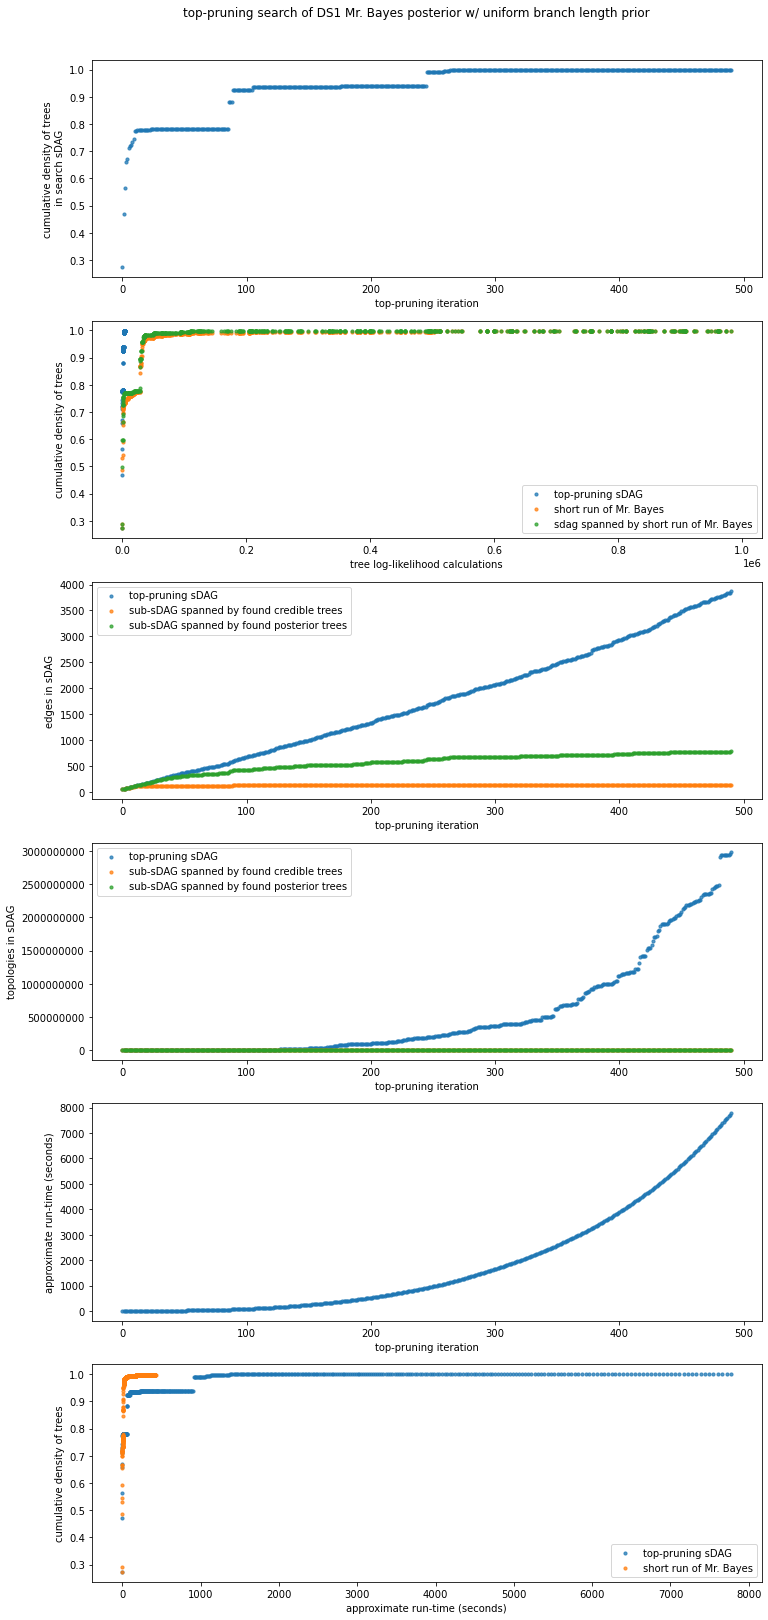

In [16]:
plot_search_results(1, "uniform", "top-pruning")

In [17]:
plot_search_results(1, "exponential", "top-pruning")

In [18]:
plot_search_results(3, "uniform", "top-pruning")

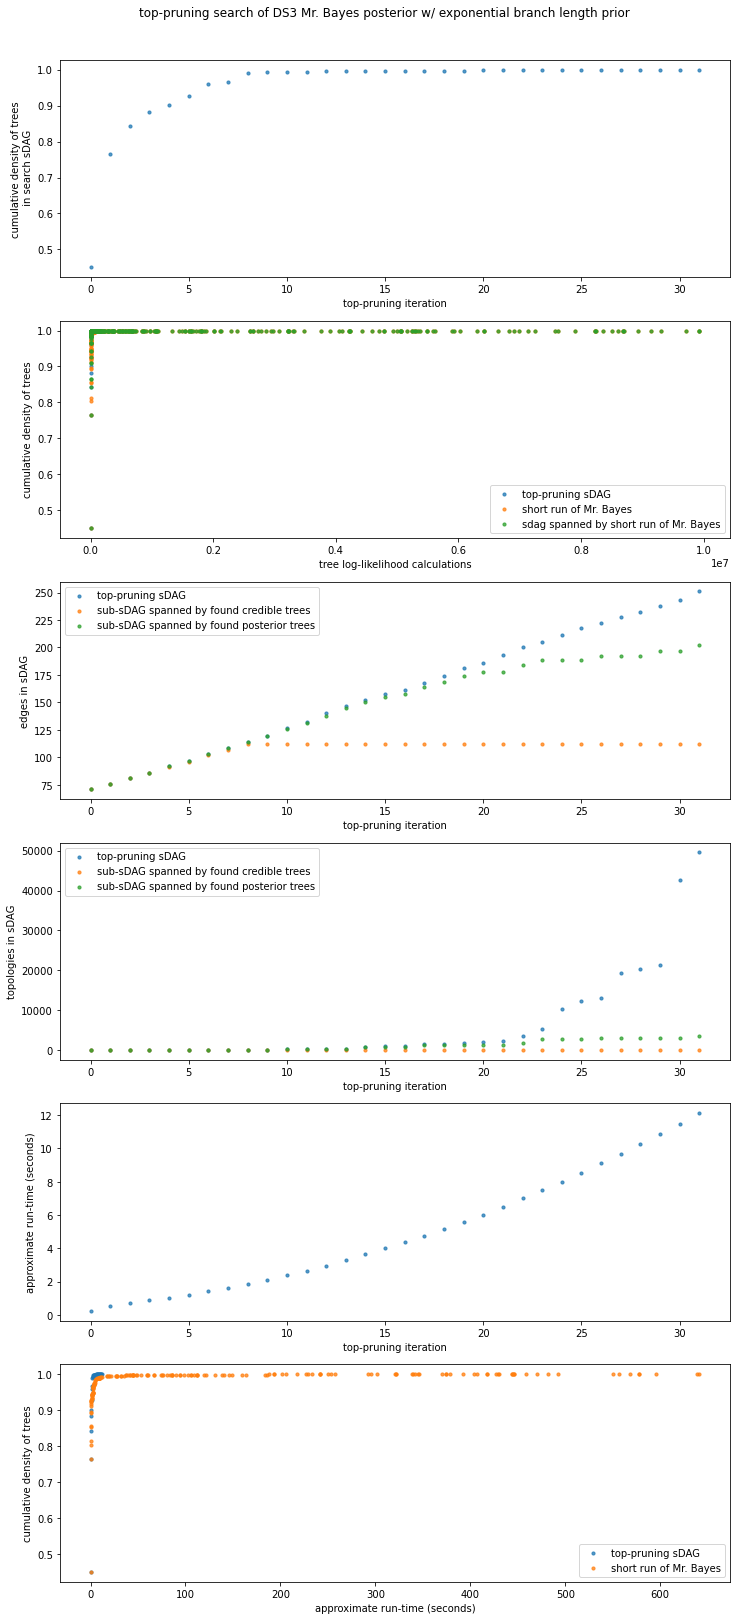

In [19]:
plot_search_results(3, "exponential", "top-pruning")

In [20]:
plot_search_results(4, "uniform", "top-pruning")

In [21]:
plot_search_results(4, "exponential", "top-pruning")

In [22]:
plot_search_results(5, "uniform", "top-pruning")

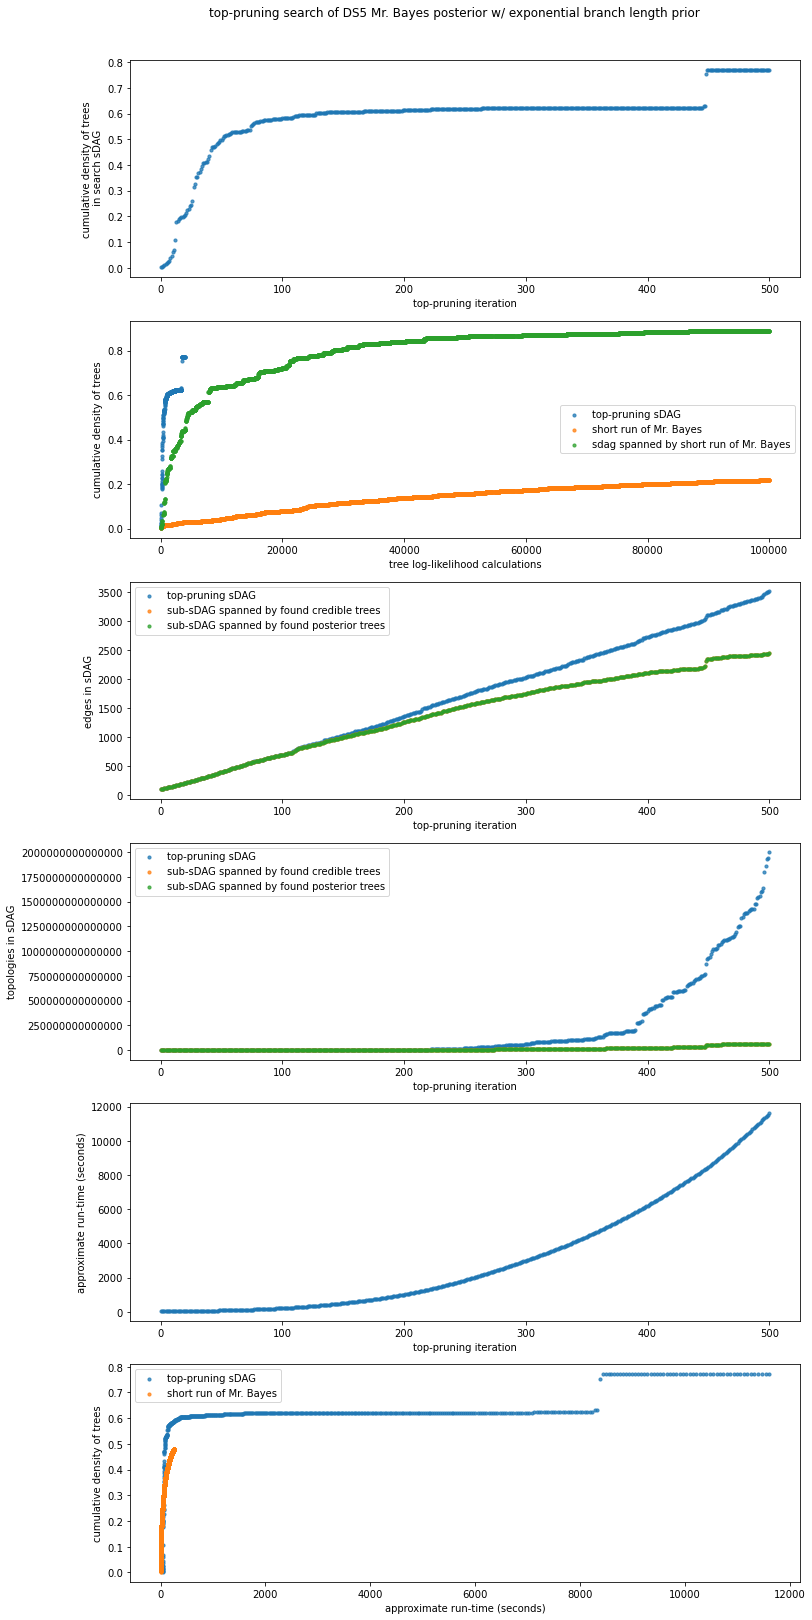

In [23]:
plot_search_results(5, "exponential", "top-pruning")

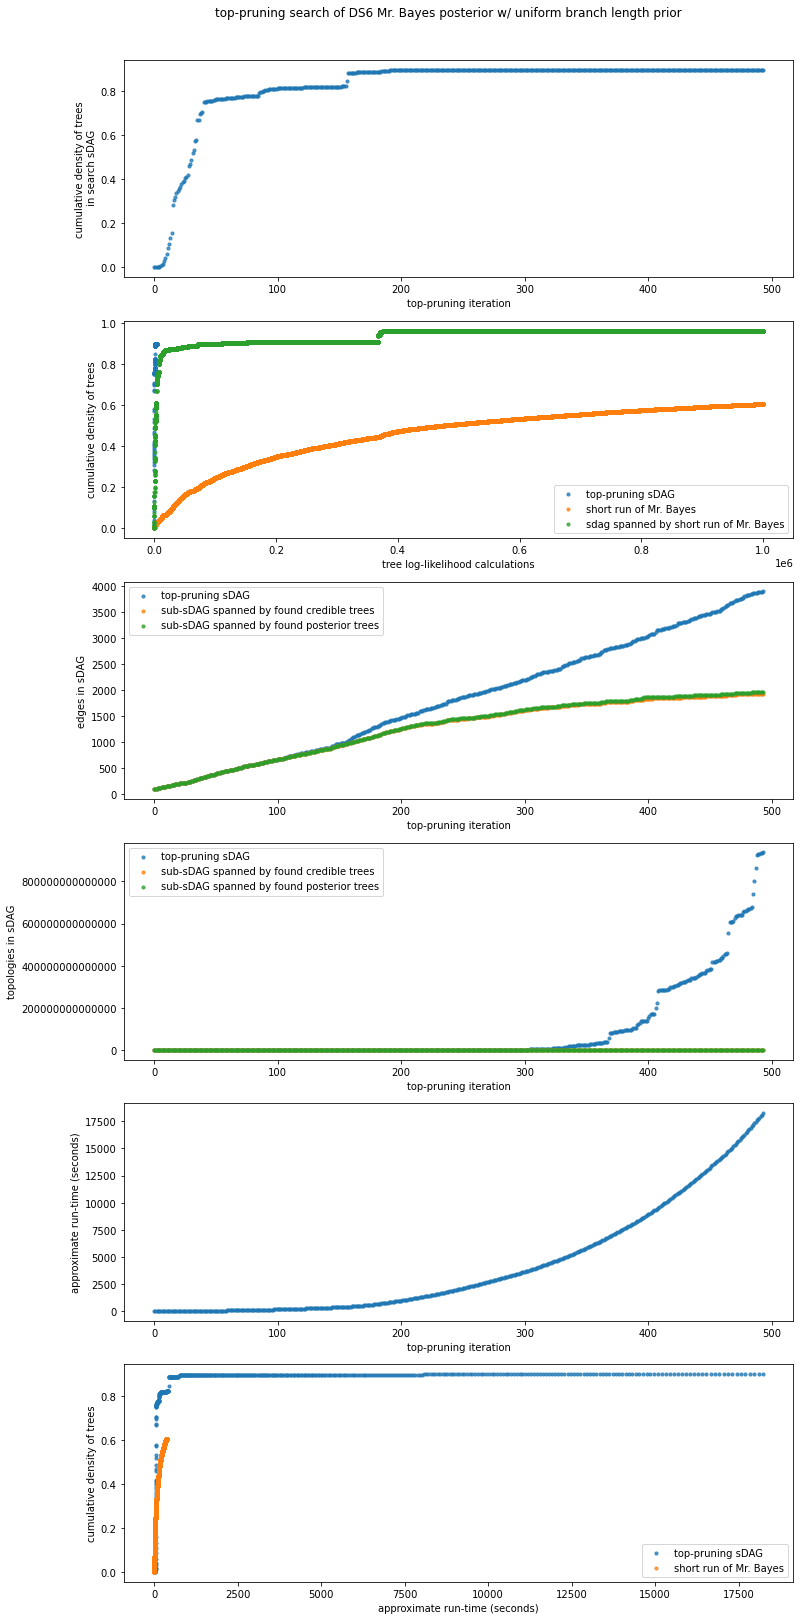

In [24]:
plot_search_results(6, "uniform", "top-pruning")

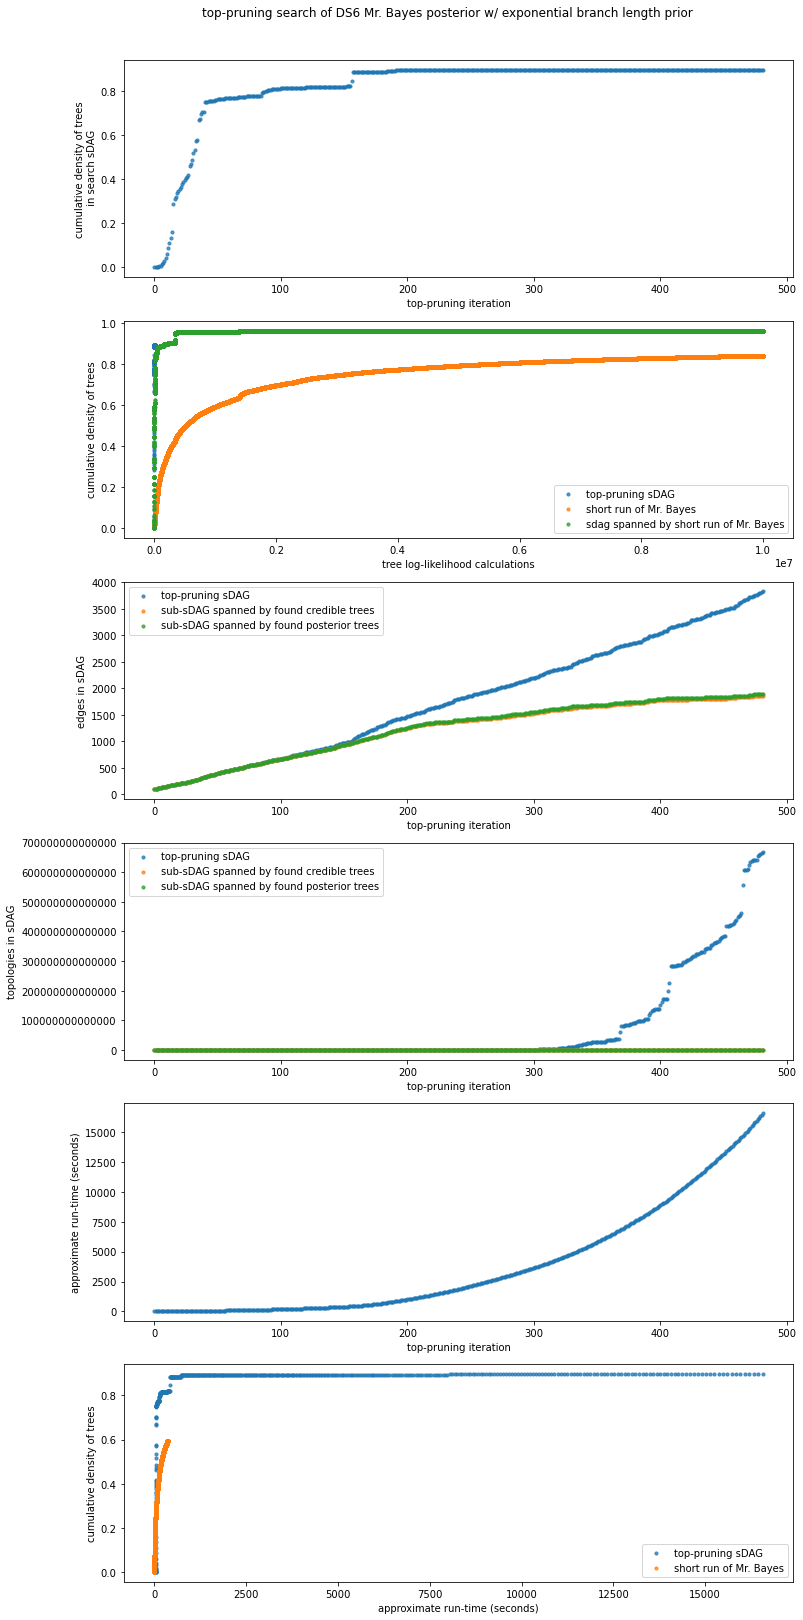

In [25]:
plot_search_results(6, "exponential", "top-pruning")

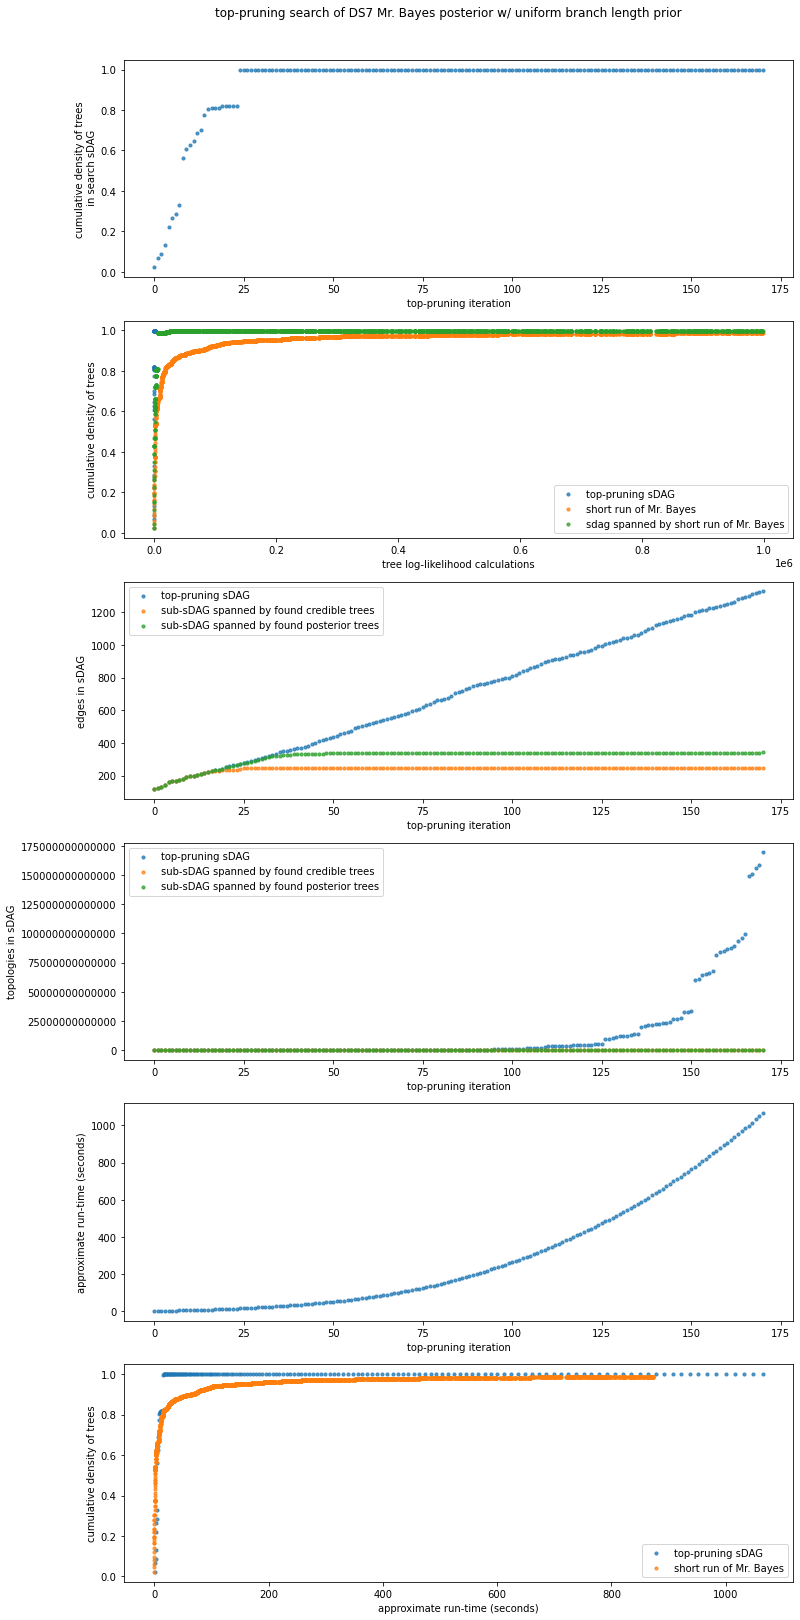

In [26]:
plot_search_results(7, "uniform", "top-pruning")

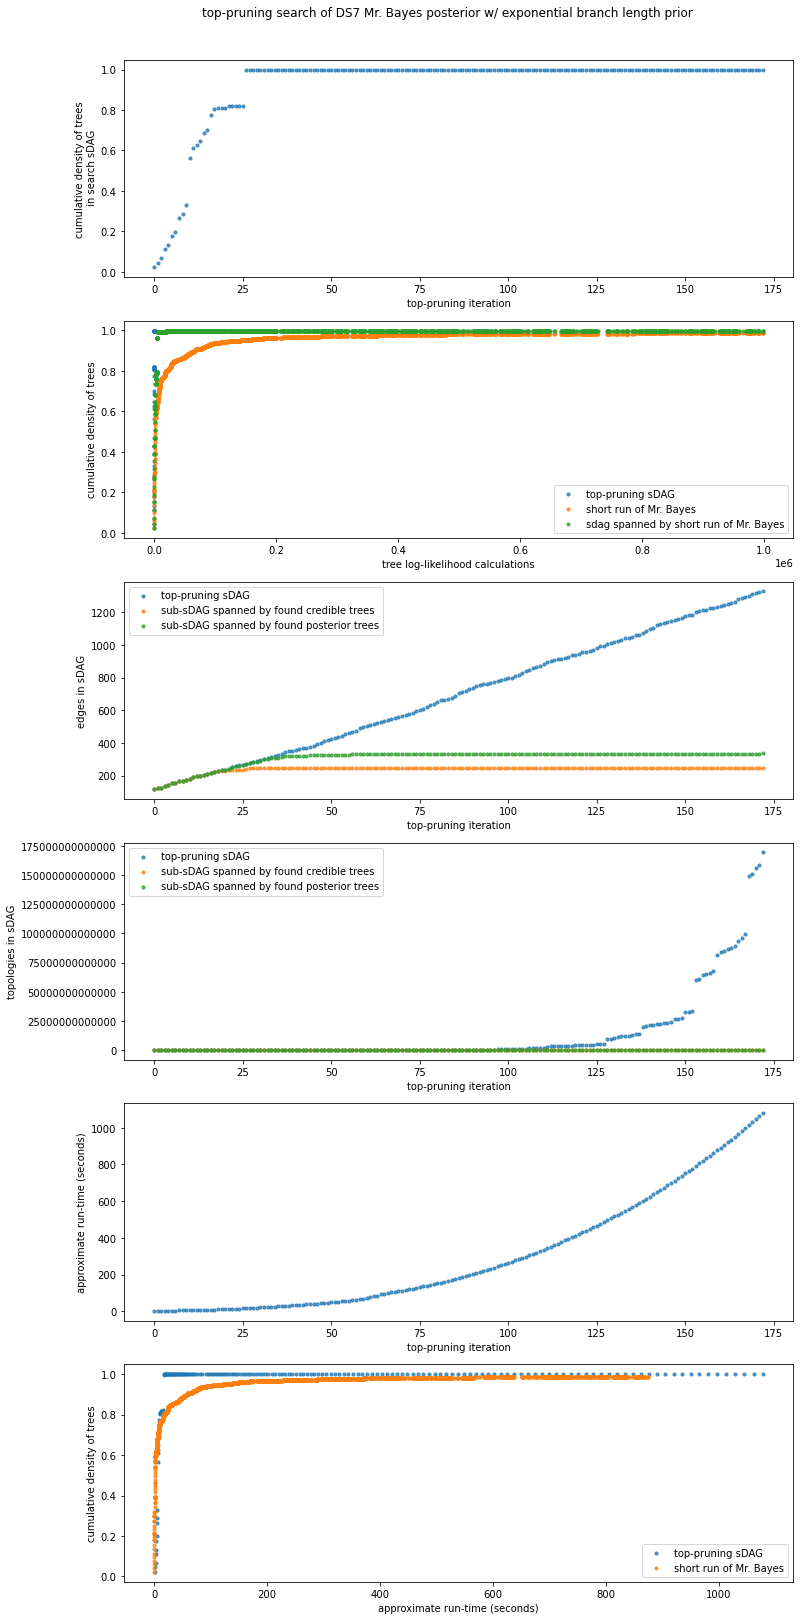

In [27]:
plot_search_results(7, "exponential", "top-pruning")

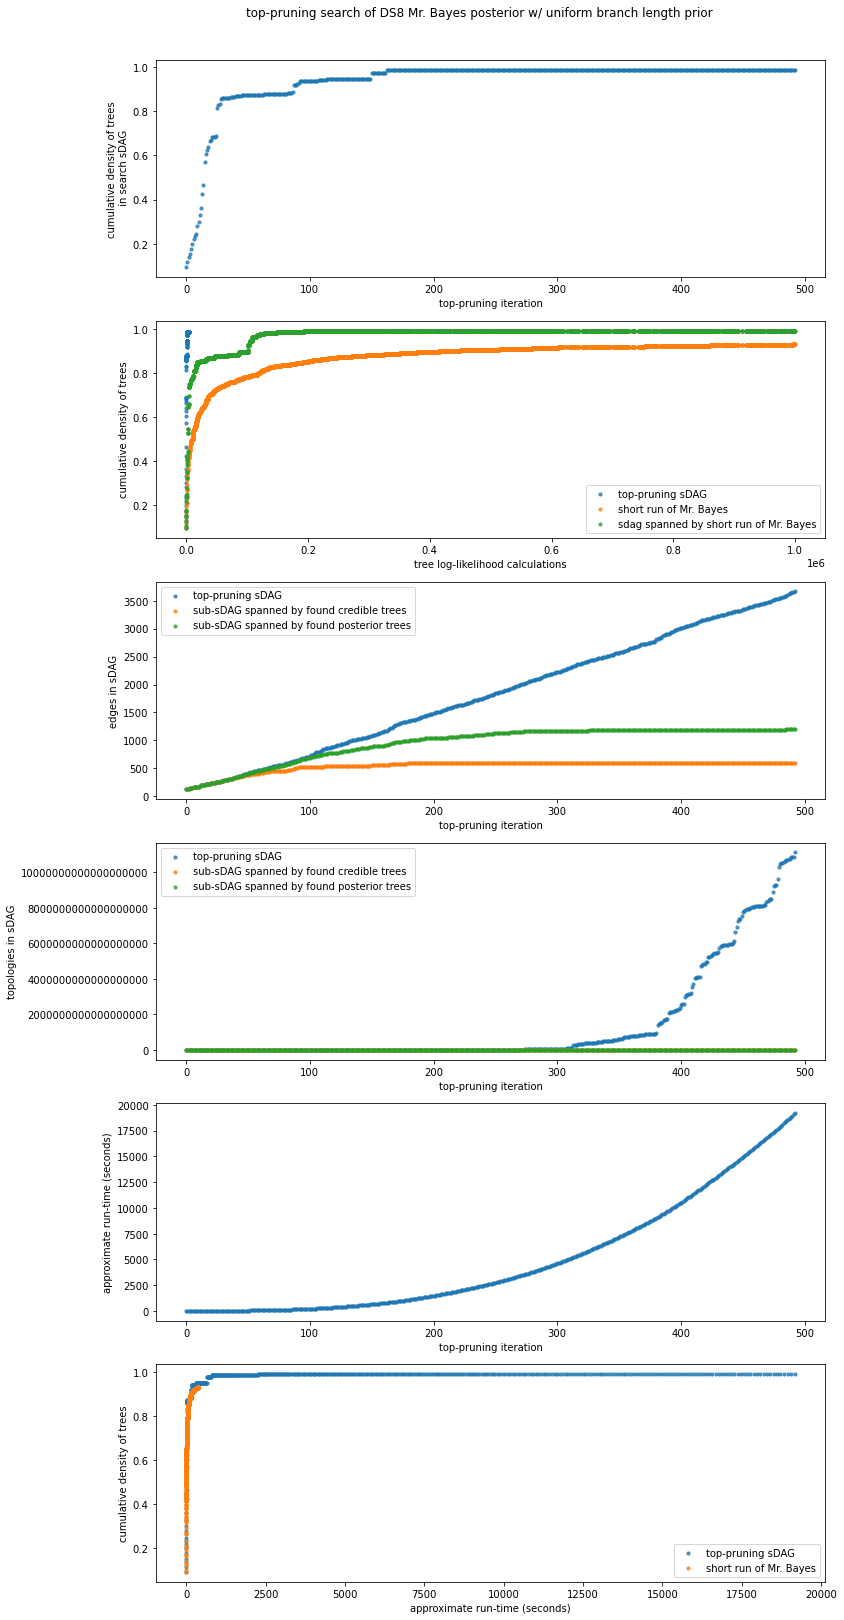

In [28]:
plot_search_results(8, "uniform", "top-pruning")

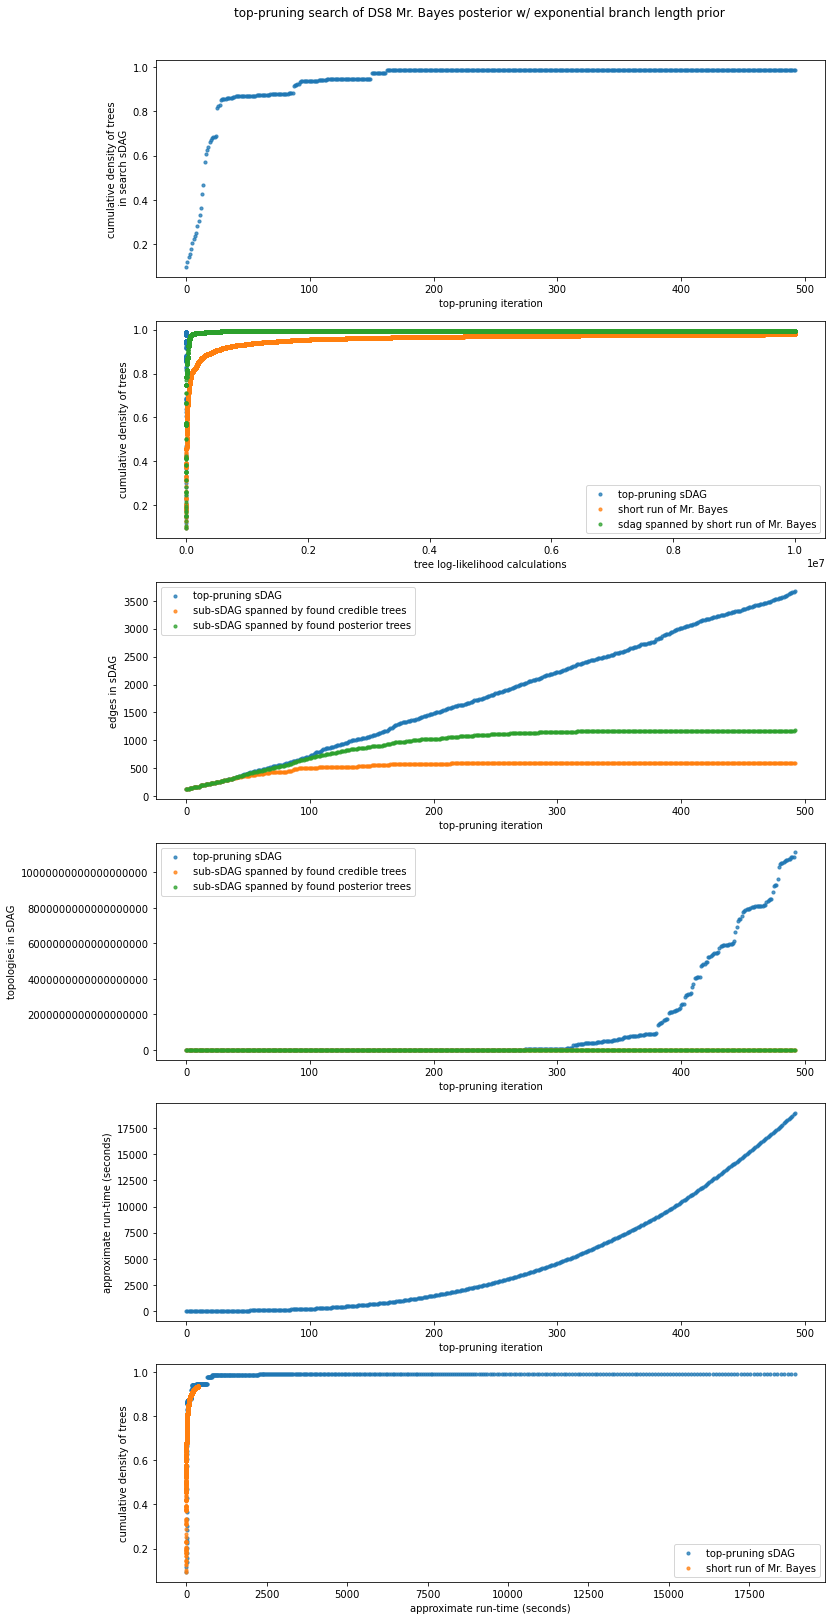

In [29]:
plot_search_results(8, "exponential", "top-pruning")

## Generalized-pruning results

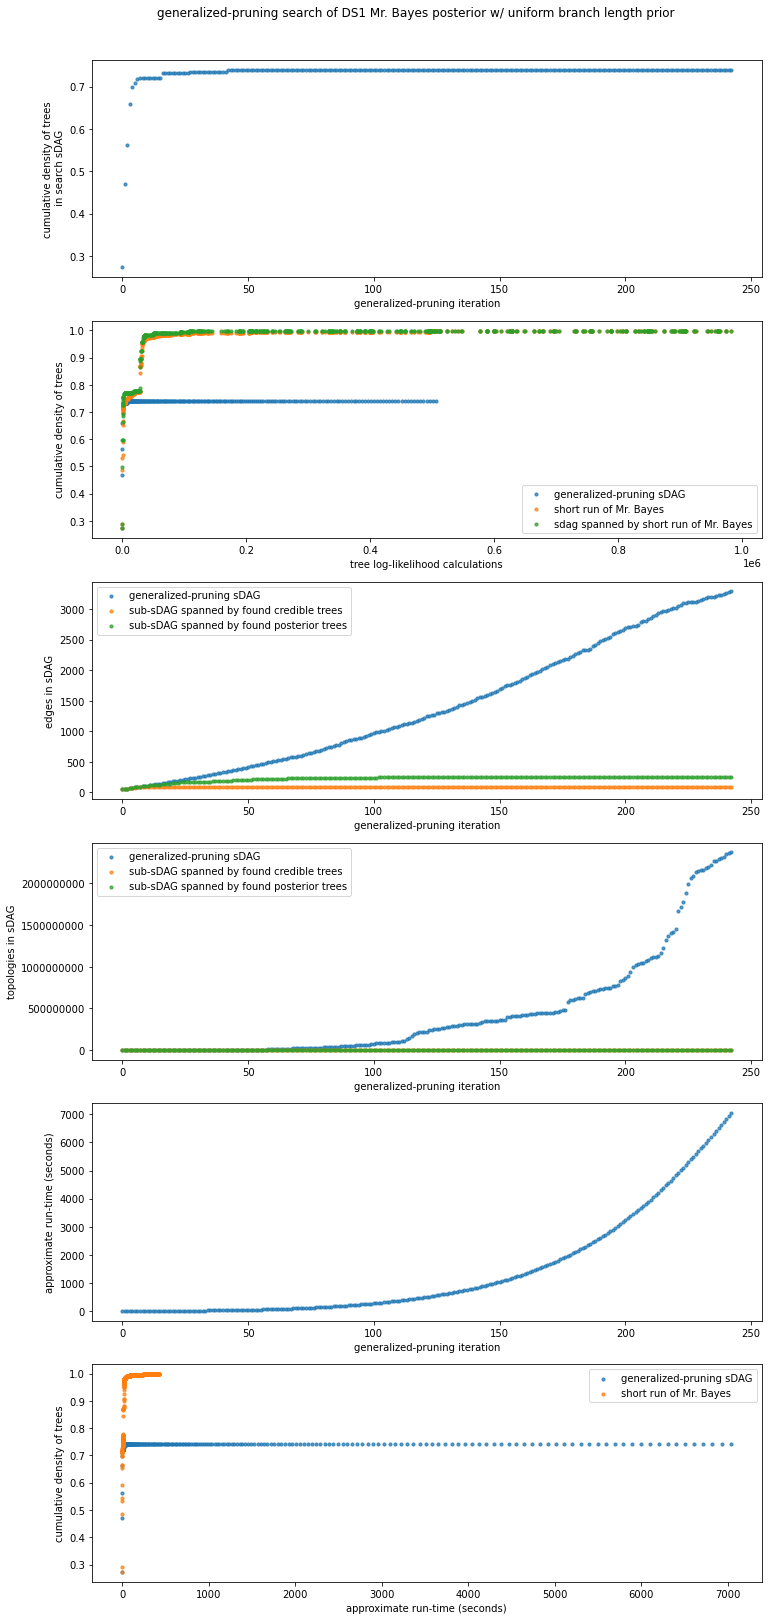

In [30]:
plot_search_results(1, "uniform", "generalized-pruning")

In [31]:
plot_search_results(1, "exponential", "generalized-pruning")

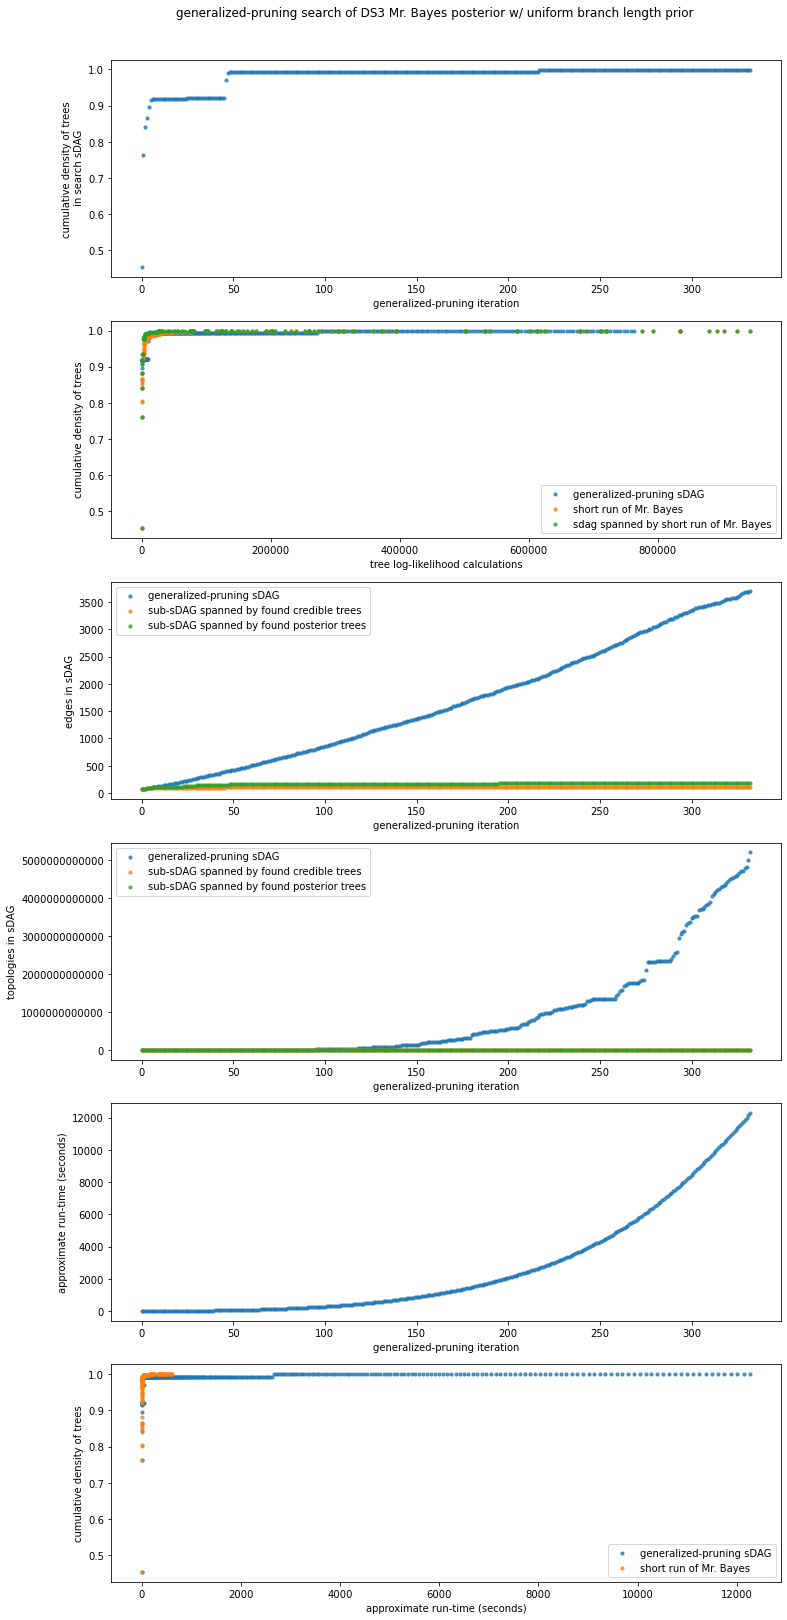

In [32]:
plot_search_results(3, "uniform", "generalized-pruning")

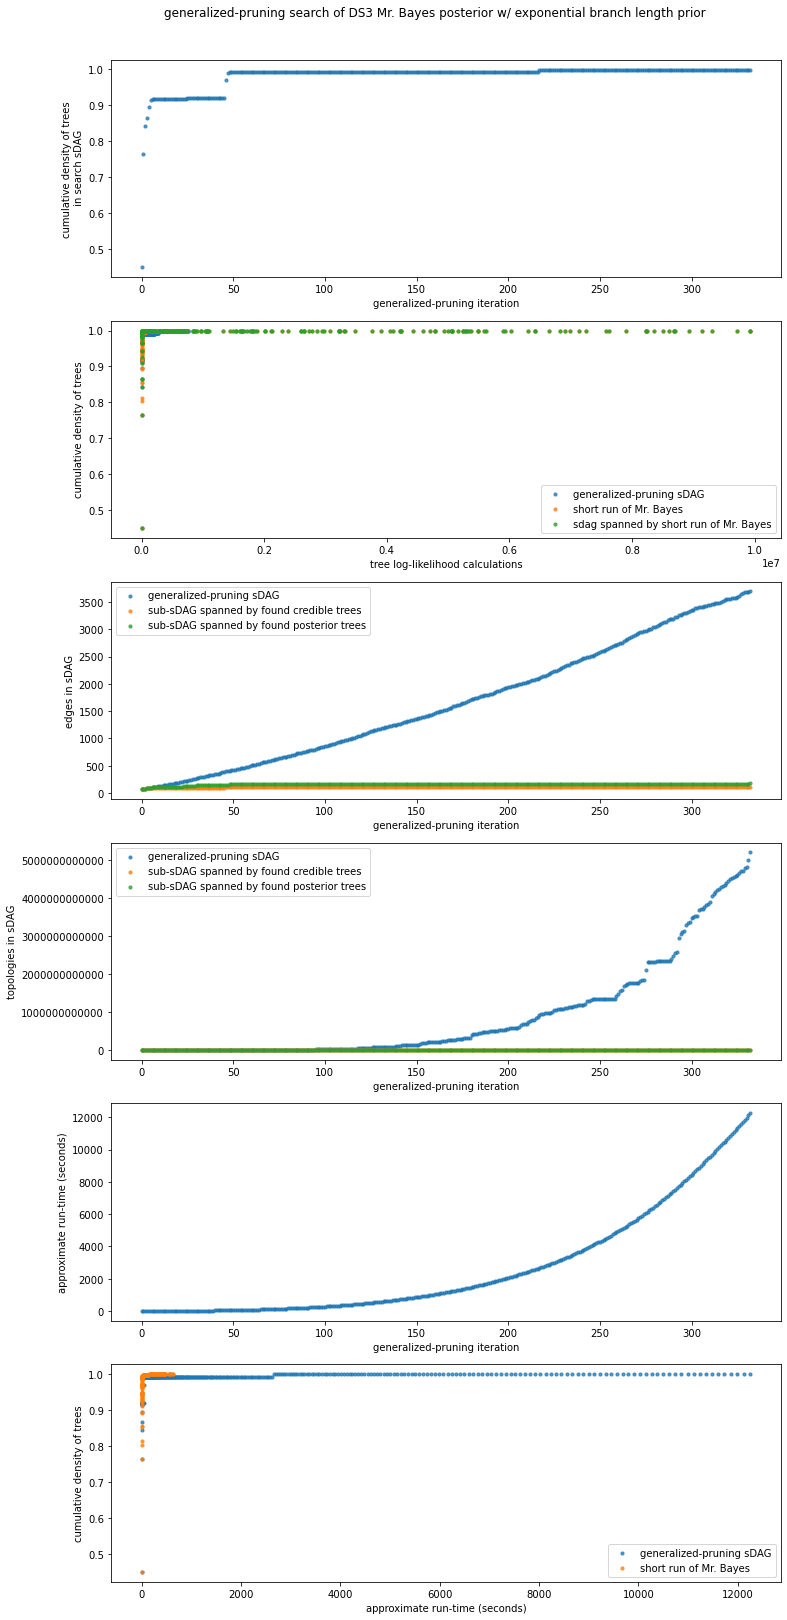

In [33]:
plot_search_results(3, "exponential", "generalized-pruning")

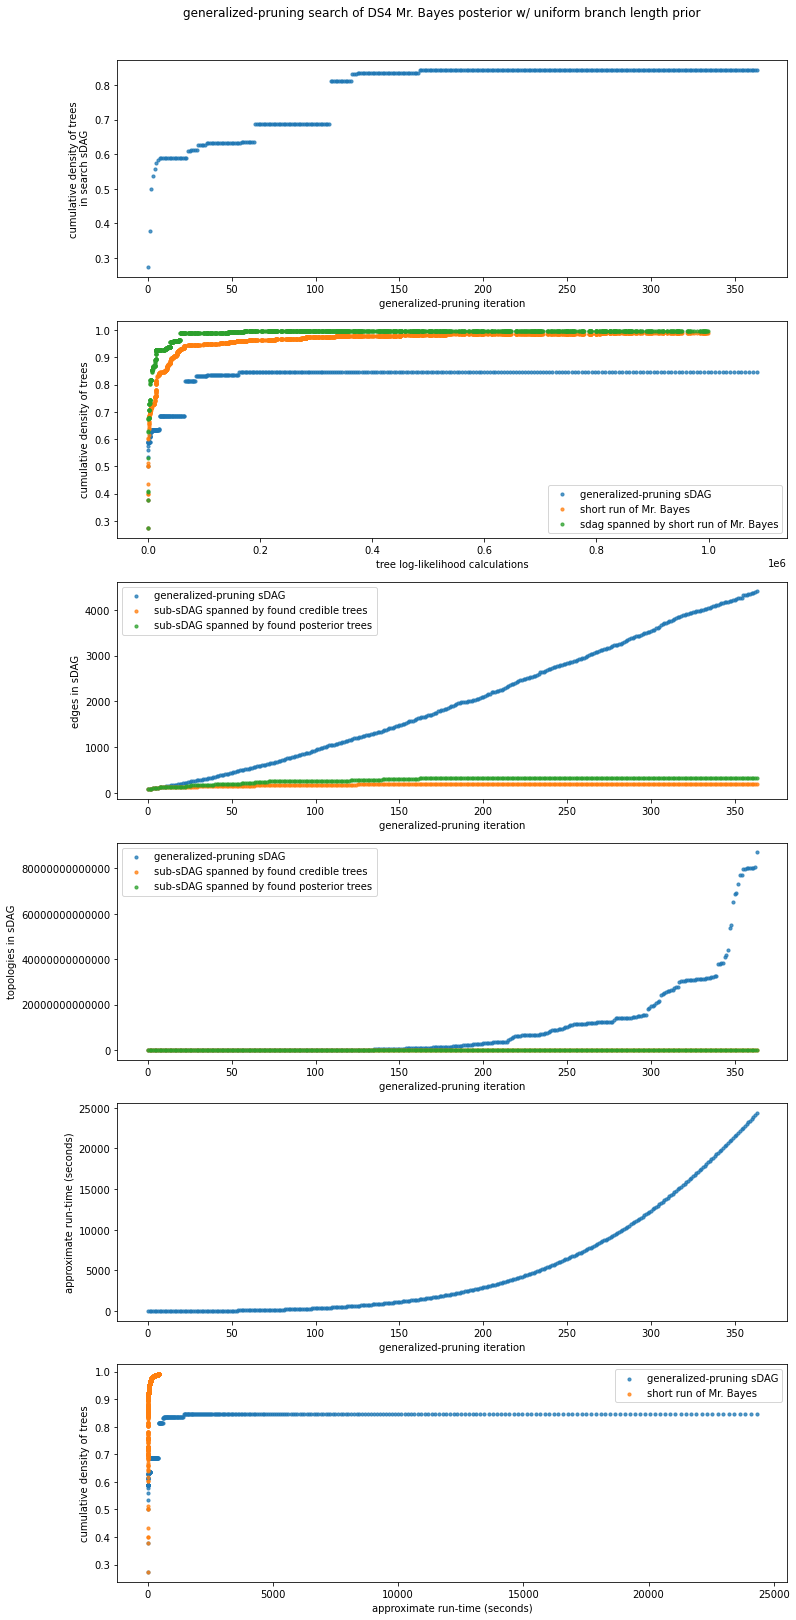

In [34]:
plot_search_results(4, "uniform", "generalized-pruning")

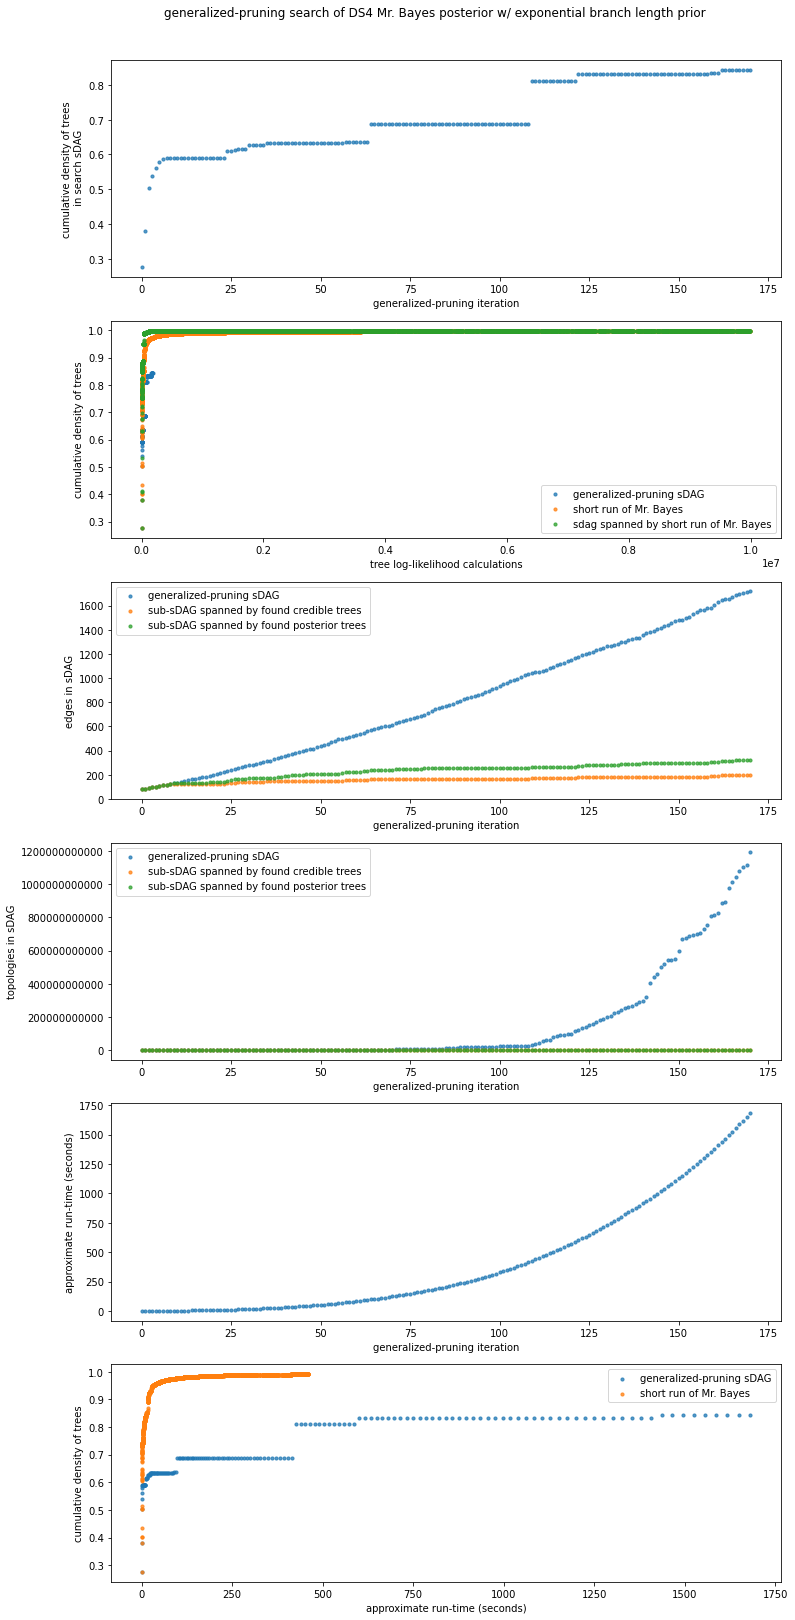

In [35]:
plot_search_results(4, "exponential", "generalized-pruning")

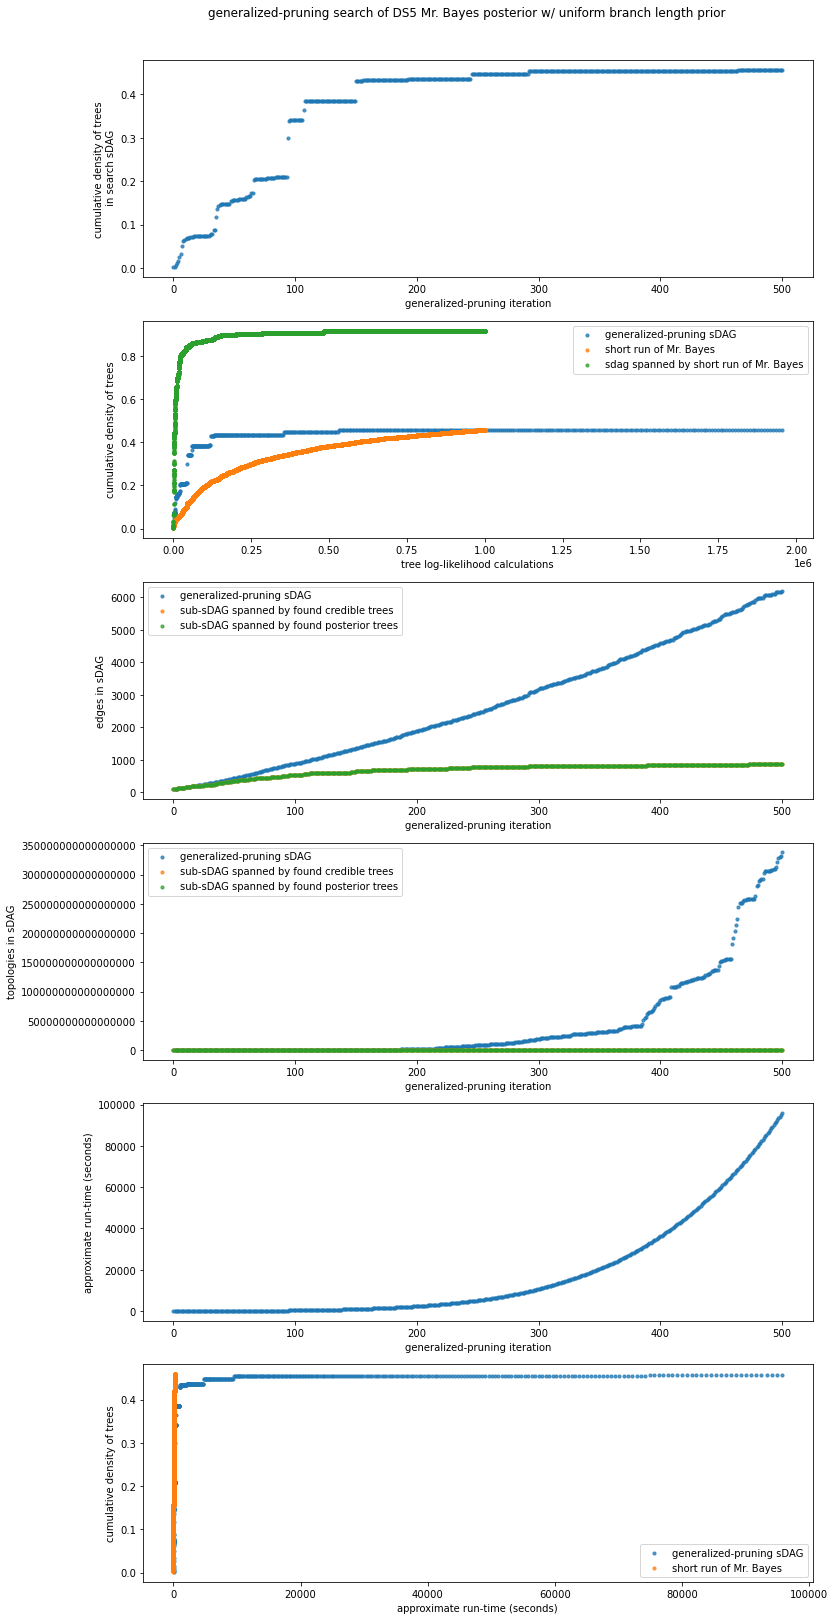

In [36]:
plot_search_results(5, "uniform", "generalized-pruning")

In [37]:
plot_search_results(5, "exponential", "generalized-pruning")

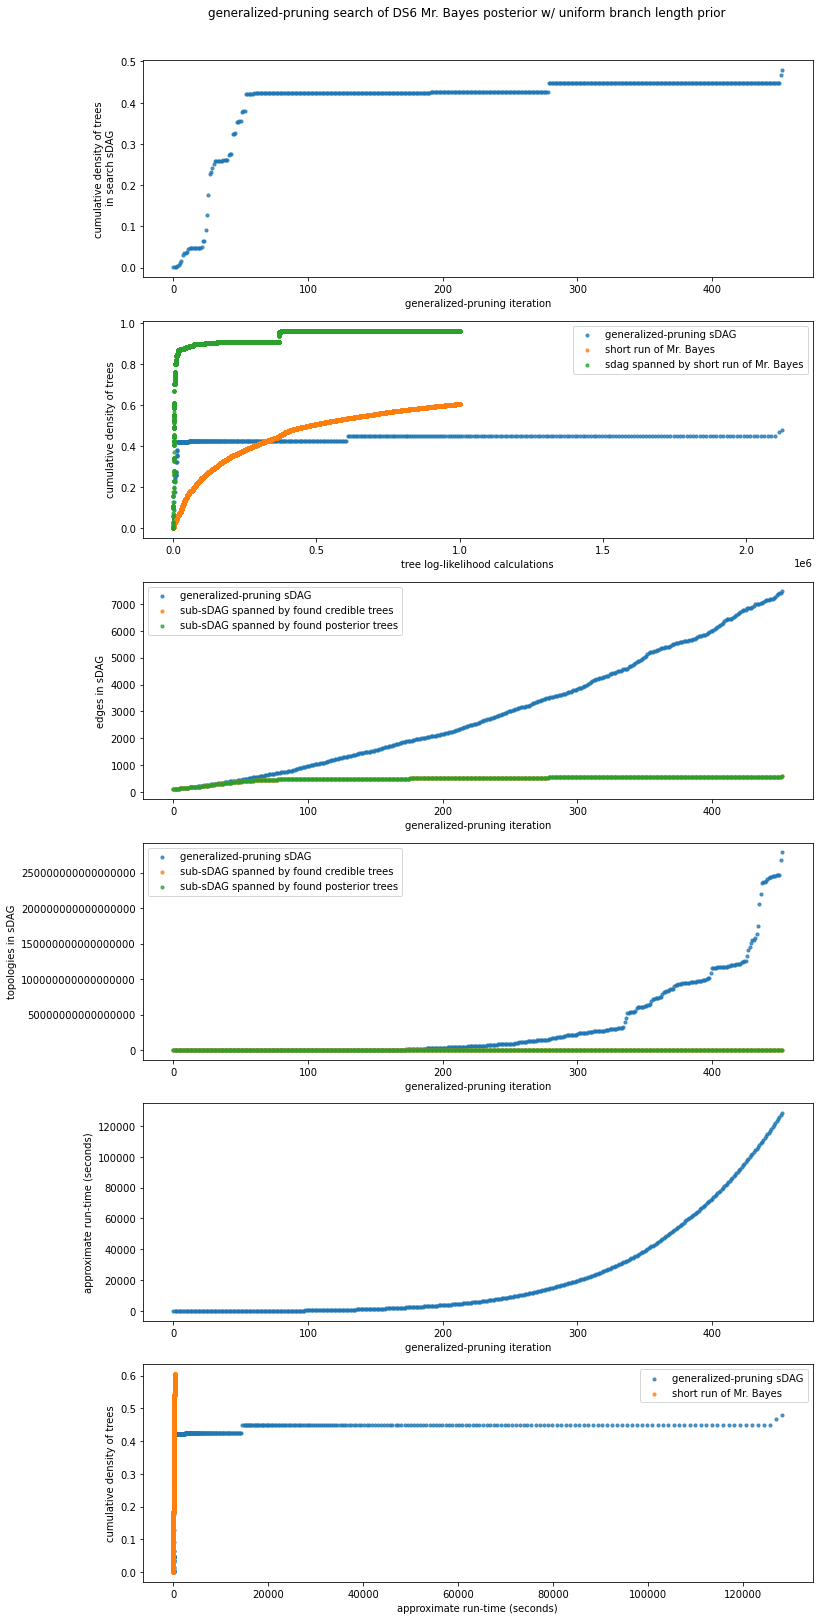

In [38]:
plot_search_results(6, "uniform", "generalized-pruning")

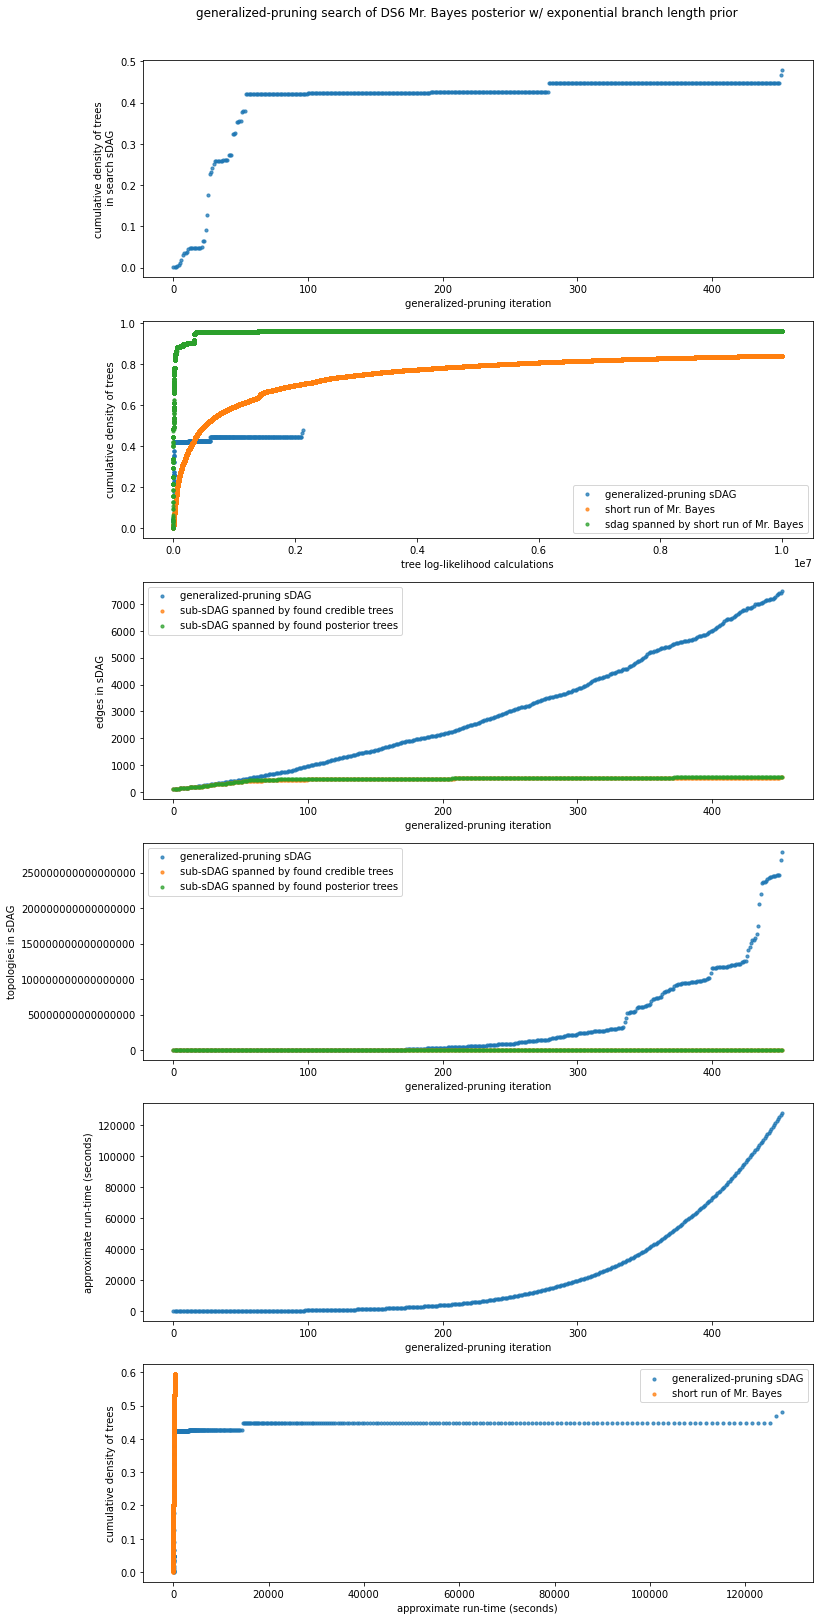

In [39]:
plot_search_results(6, "exponential", "generalized-pruning")

In [40]:
plot_search_results(7, "uniform", "generalized-pruning")

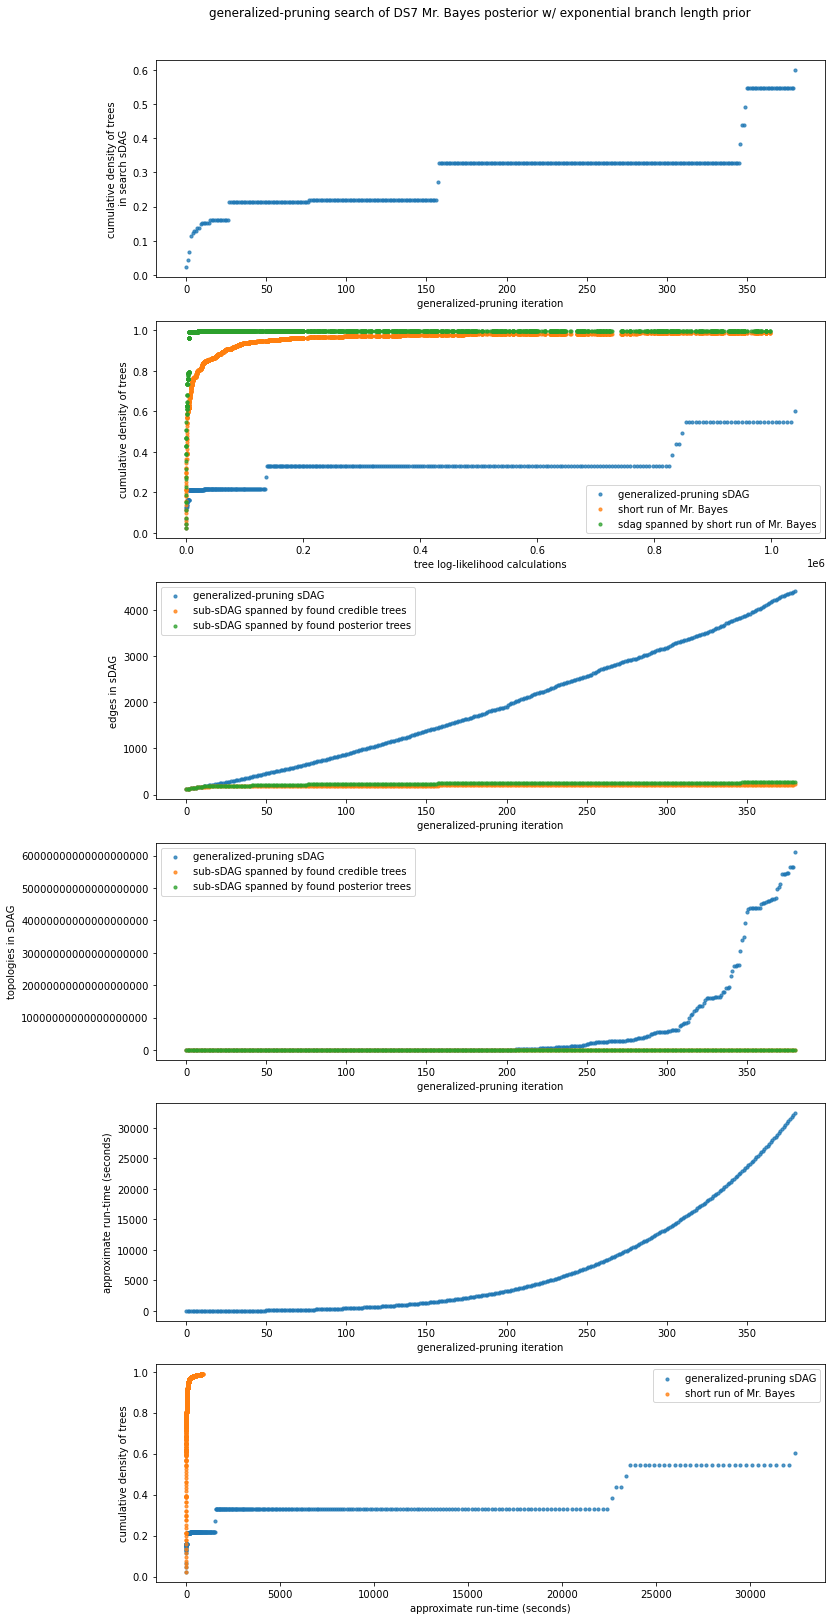

In [41]:
plot_search_results(7, "exponential", "generalized-pruning")

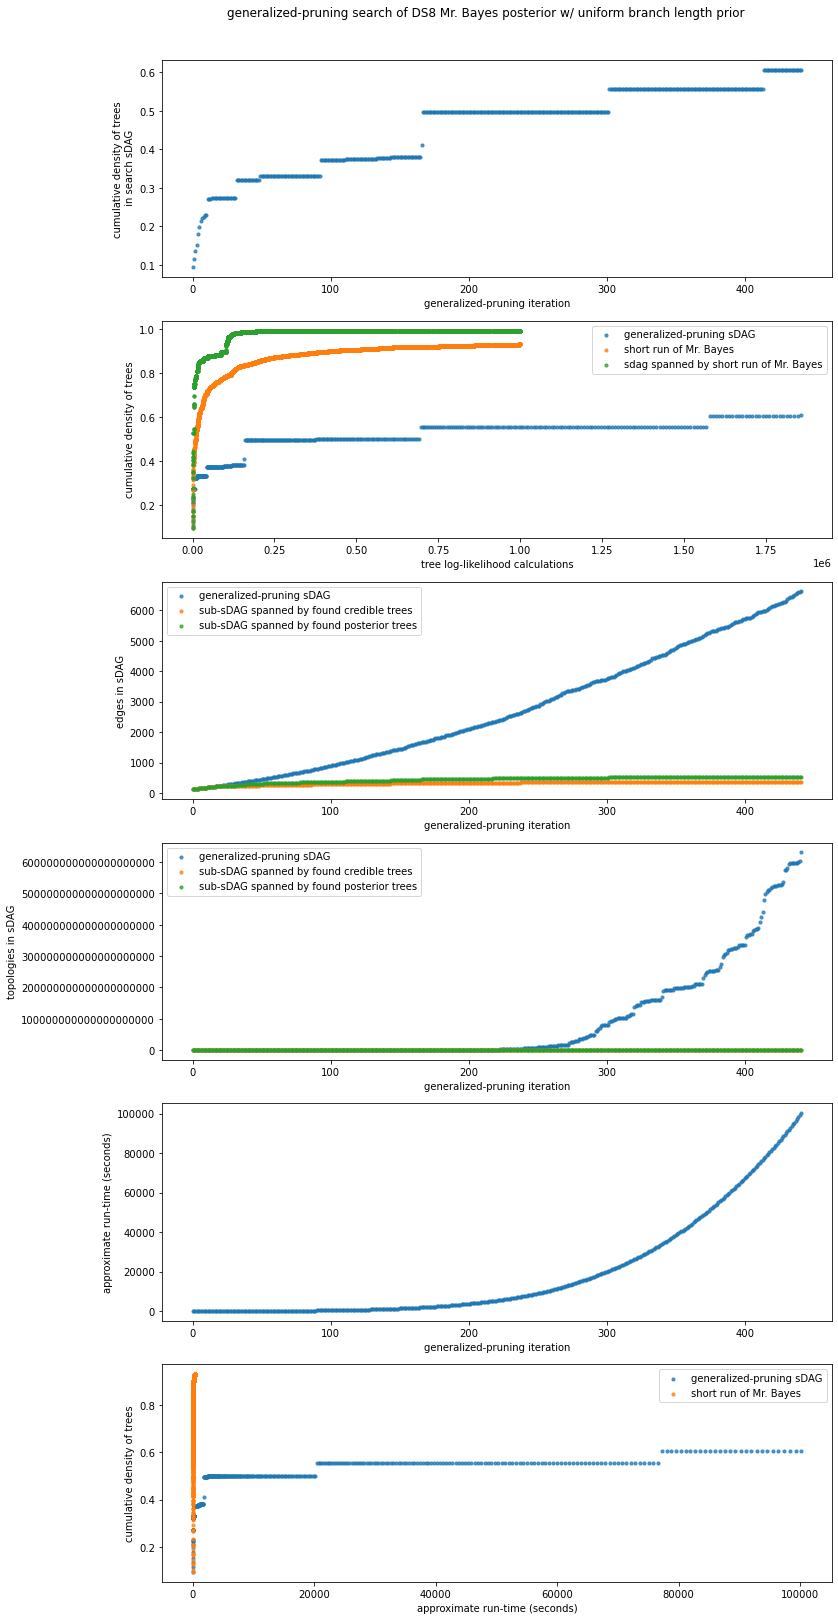

In [42]:
plot_search_results(8, "uniform", "generalized-pruning")

In [43]:
plot_search_results(8, "exponential", "generalized-pruning")

## Run-time performance

In [44]:
plot_timing_results(1, "uniform", "top-pruning")

In [45]:
plot_timing_results(3, "uniform", "top-pruning")

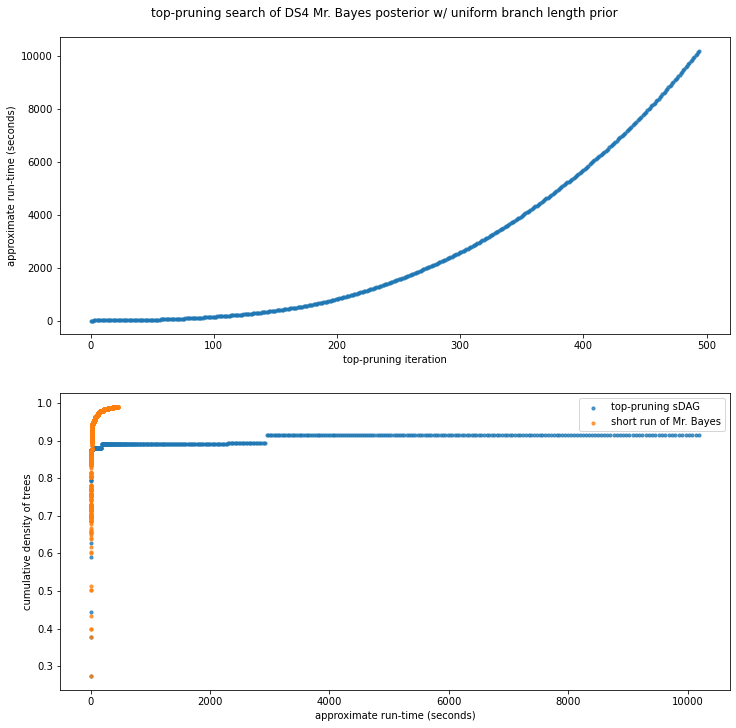

In [46]:
plot_timing_results(4, "uniform", "top-pruning")

In [47]:
plot_timing_results(5, "uniform", "top-pruning")

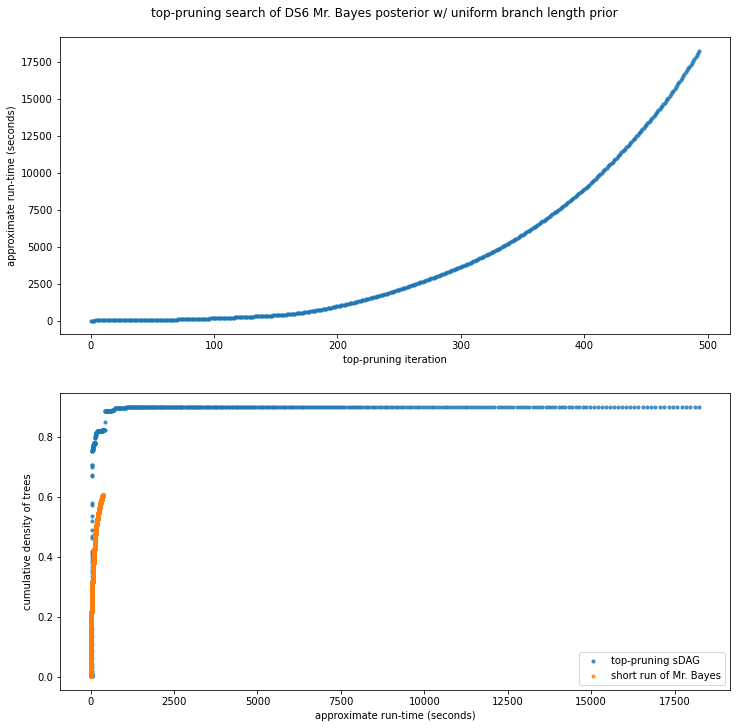

In [48]:
plot_timing_results(6, "uniform", "top-pruning")

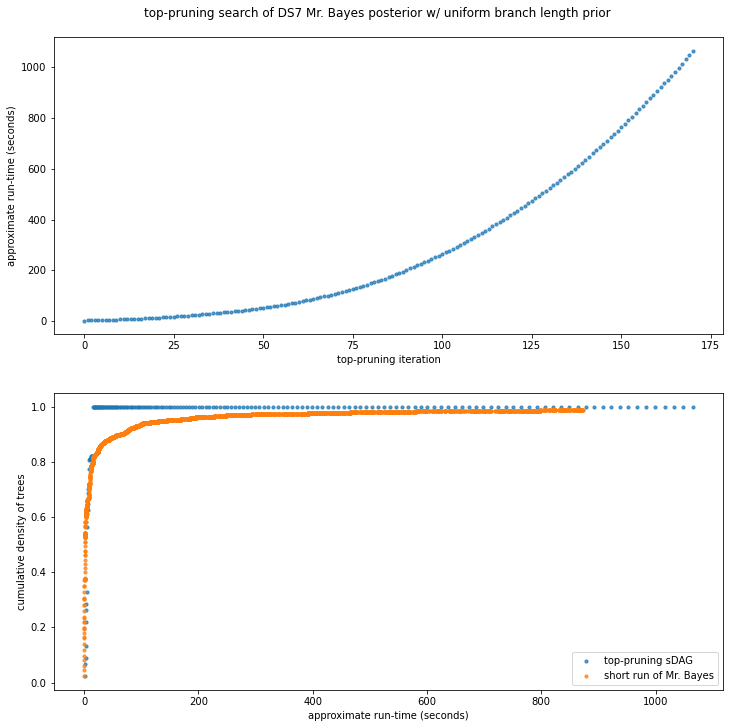

In [49]:
plot_timing_results(7, "uniform", "top-pruning")

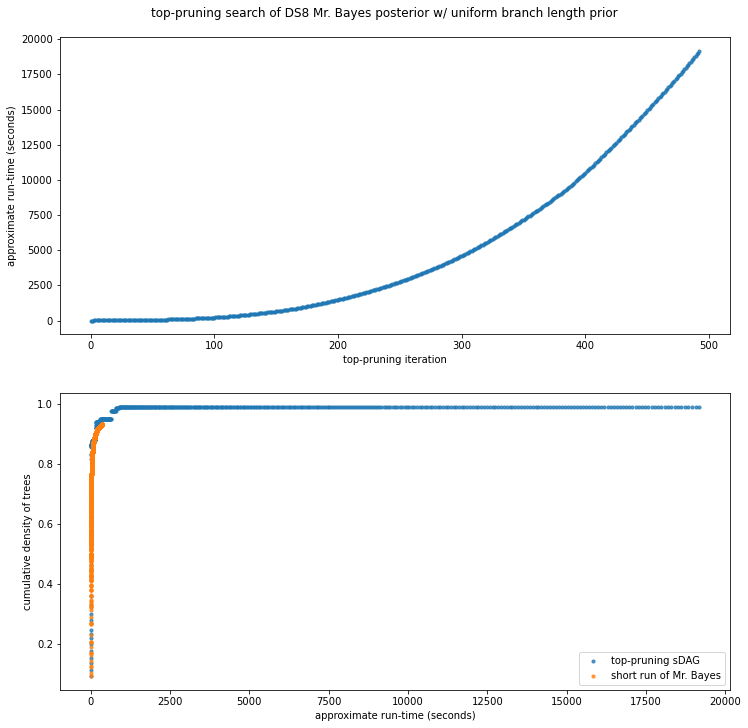

In [50]:
plot_timing_results(8, "uniform", "top-pruning")

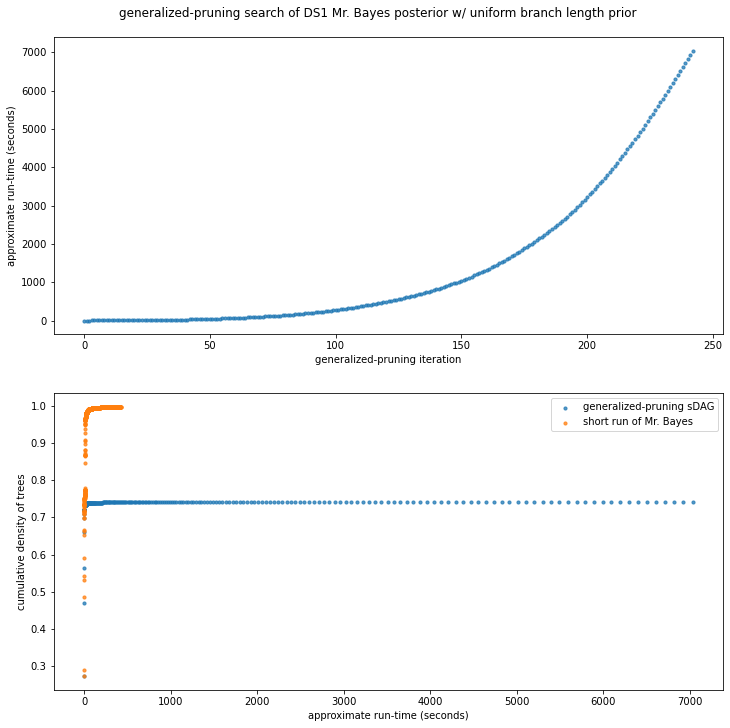

In [51]:
plot_timing_results(1, "uniform", "generalized-pruning")

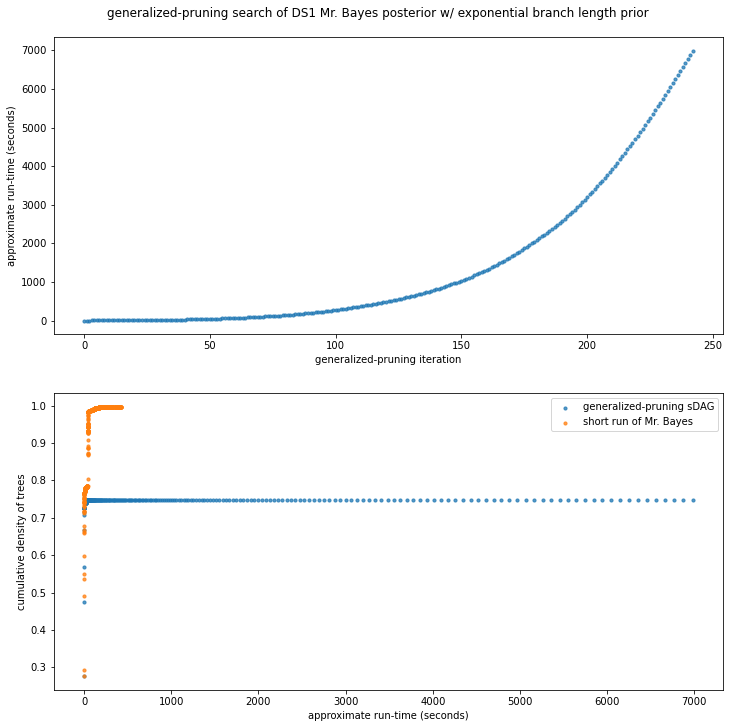

In [52]:
plot_timing_results(1, "exponential", "generalized-pruning")

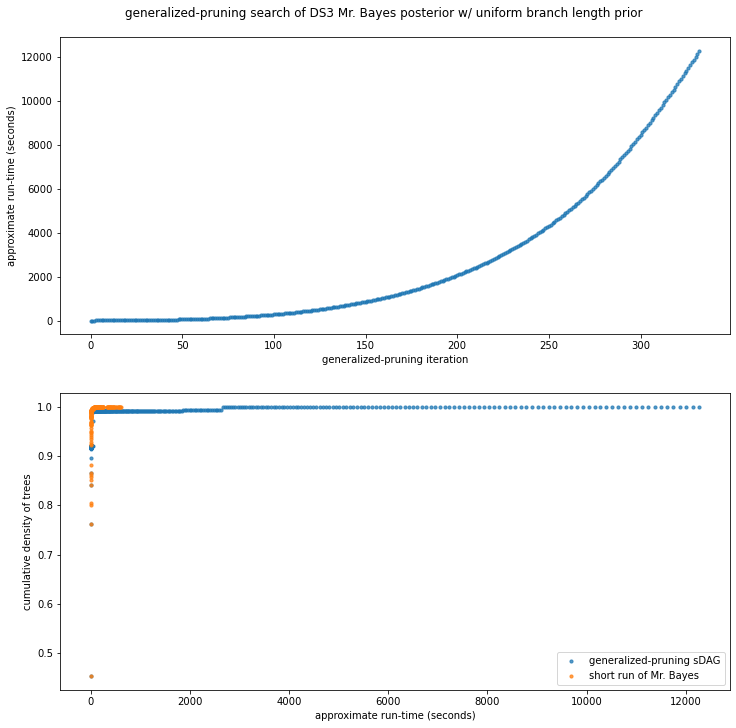

In [53]:
plot_timing_results(3, "uniform", "generalized-pruning")

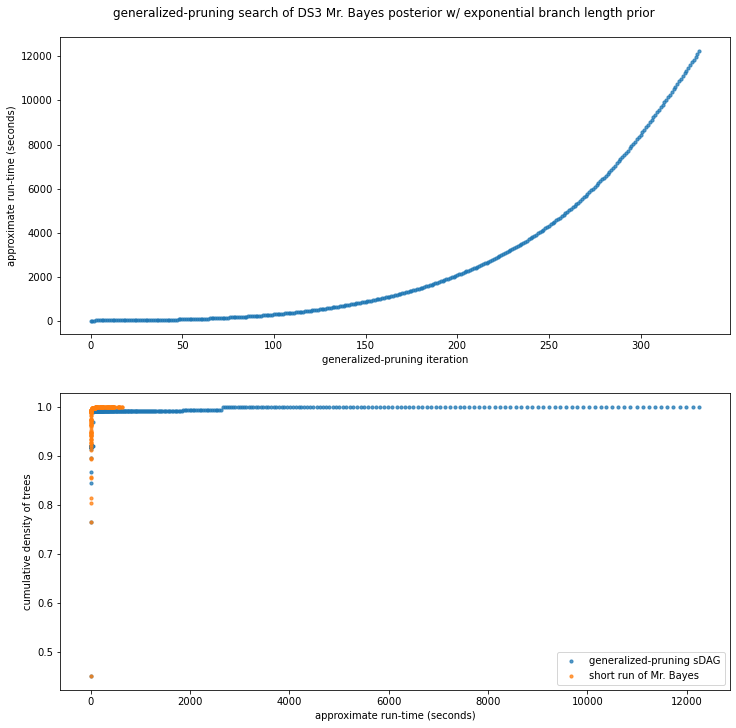

In [54]:
plot_timing_results(3, "exponential", "generalized-pruning")

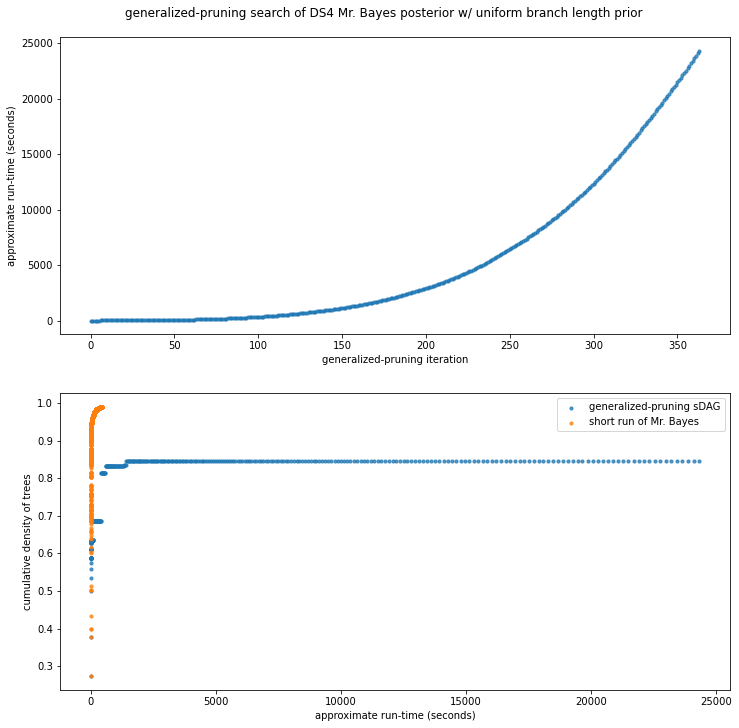

In [55]:
plot_timing_results(4, "uniform", "generalized-pruning")

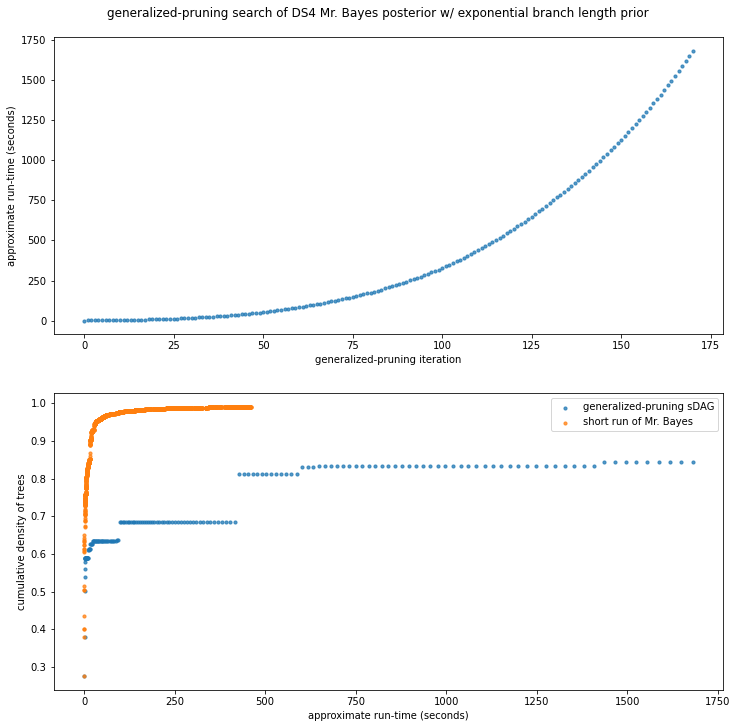

In [56]:
plot_timing_results(4, "exponential", "generalized-pruning")

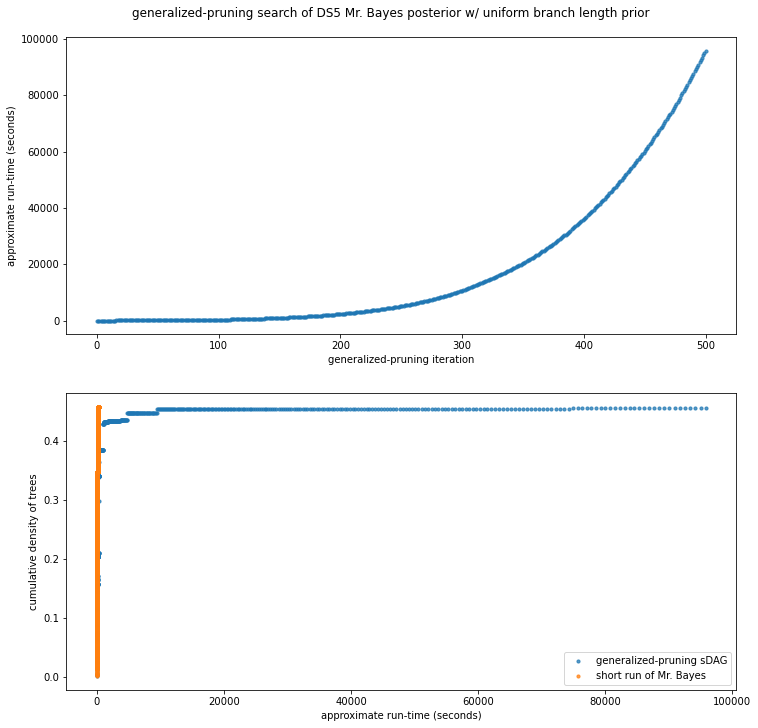

In [57]:
plot_timing_results(5, "uniform", "generalized-pruning")

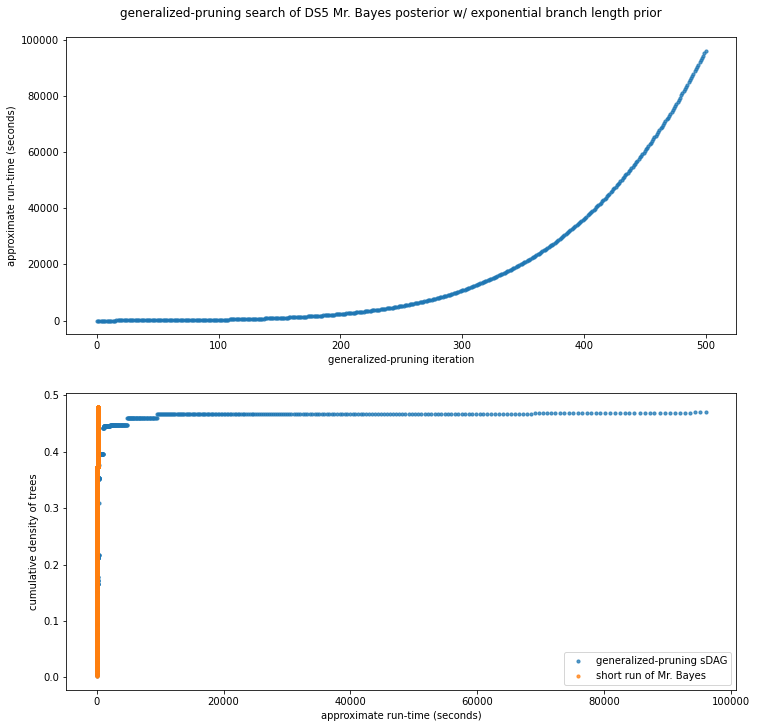

In [58]:
plot_timing_results(5, "exponential", "generalized-pruning")

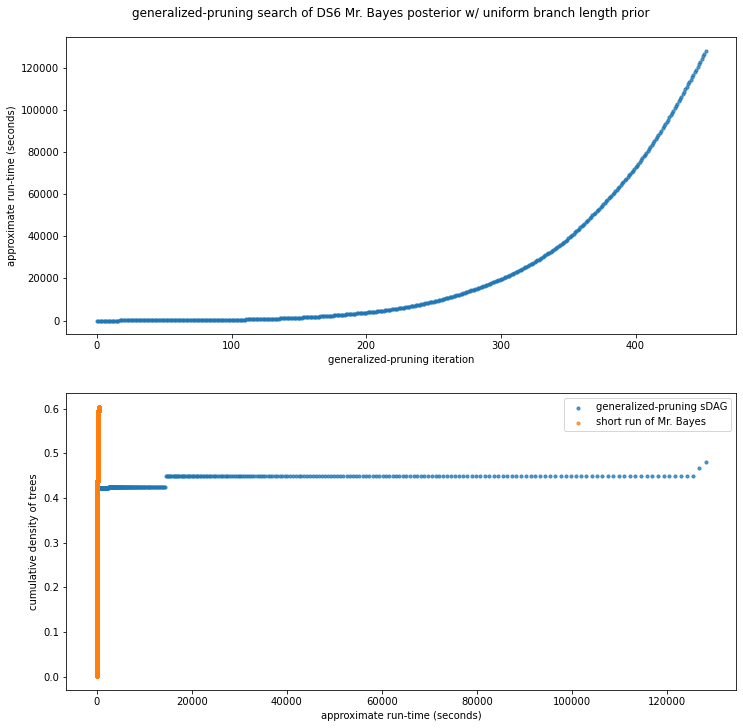

In [59]:
plot_timing_results(6, "uniform", "generalized-pruning")

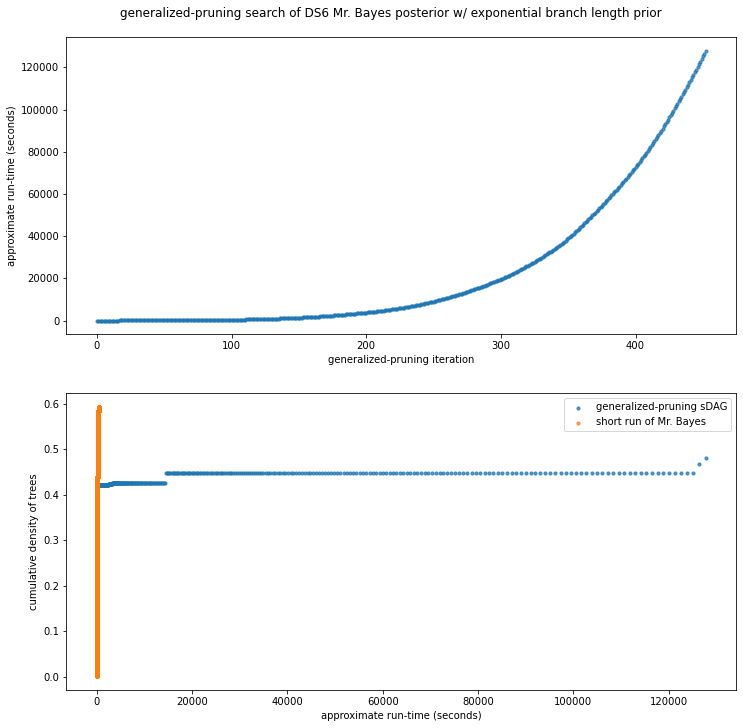

In [60]:
plot_timing_results(6, "exponential", "generalized-pruning")

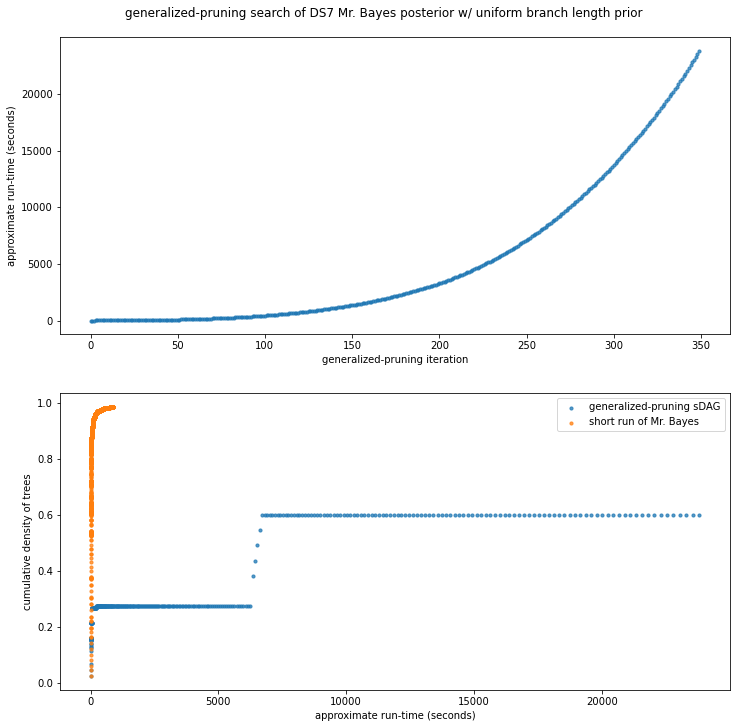

In [61]:
plot_timing_results(7, "uniform", "generalized-pruning")

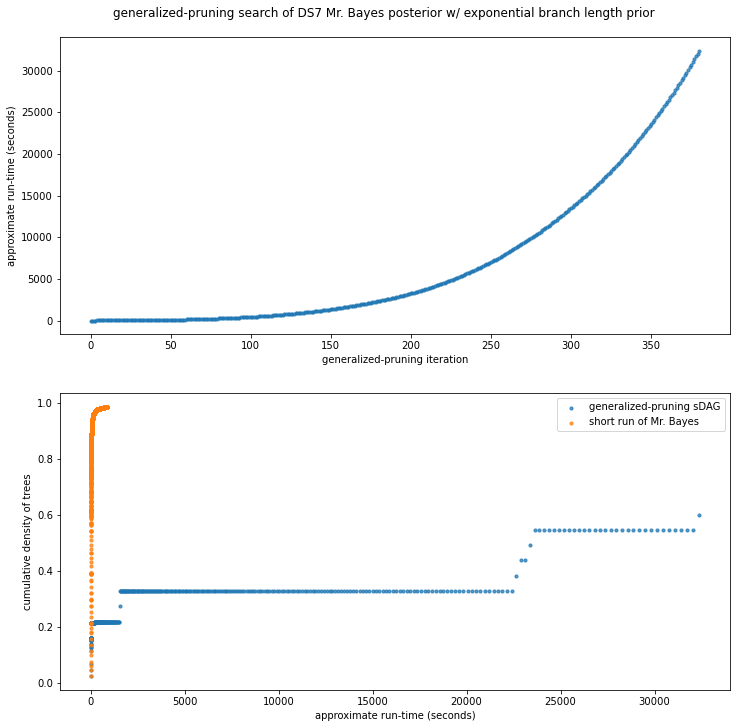

In [62]:
plot_timing_results(7, "exponential", "generalized-pruning")

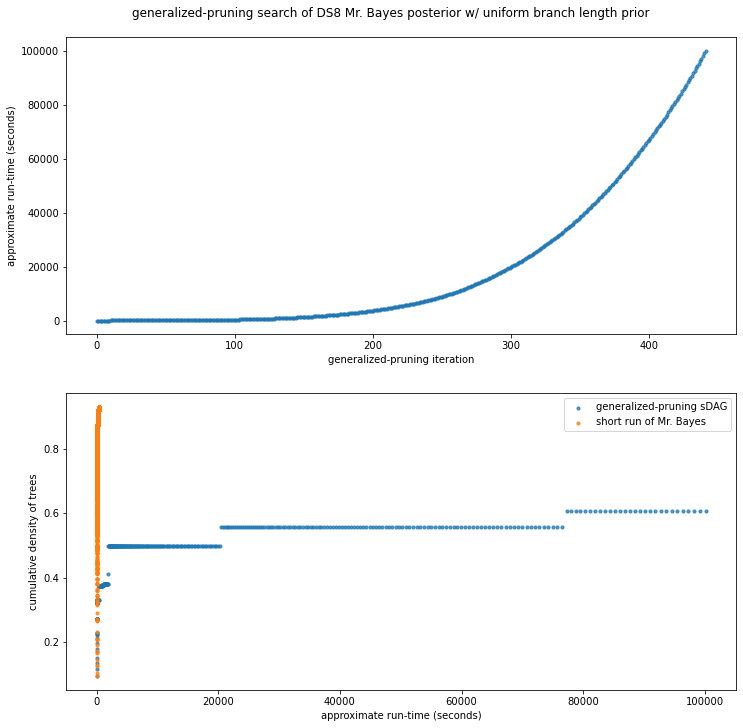

In [63]:
plot_timing_results(8, "uniform", "generalized-pruning")

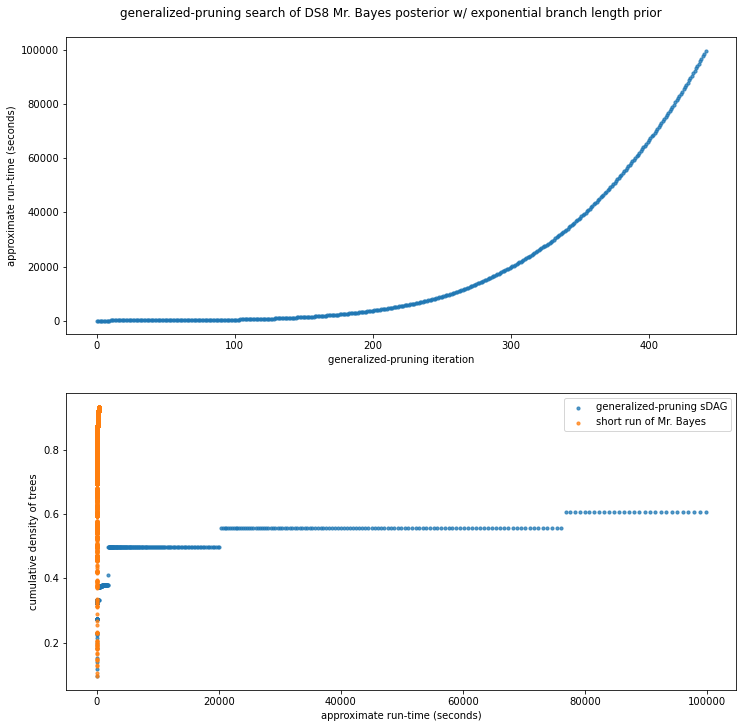

In [64]:
plot_timing_results(8, "exponential", "generalized-pruning")

# Plots for write up

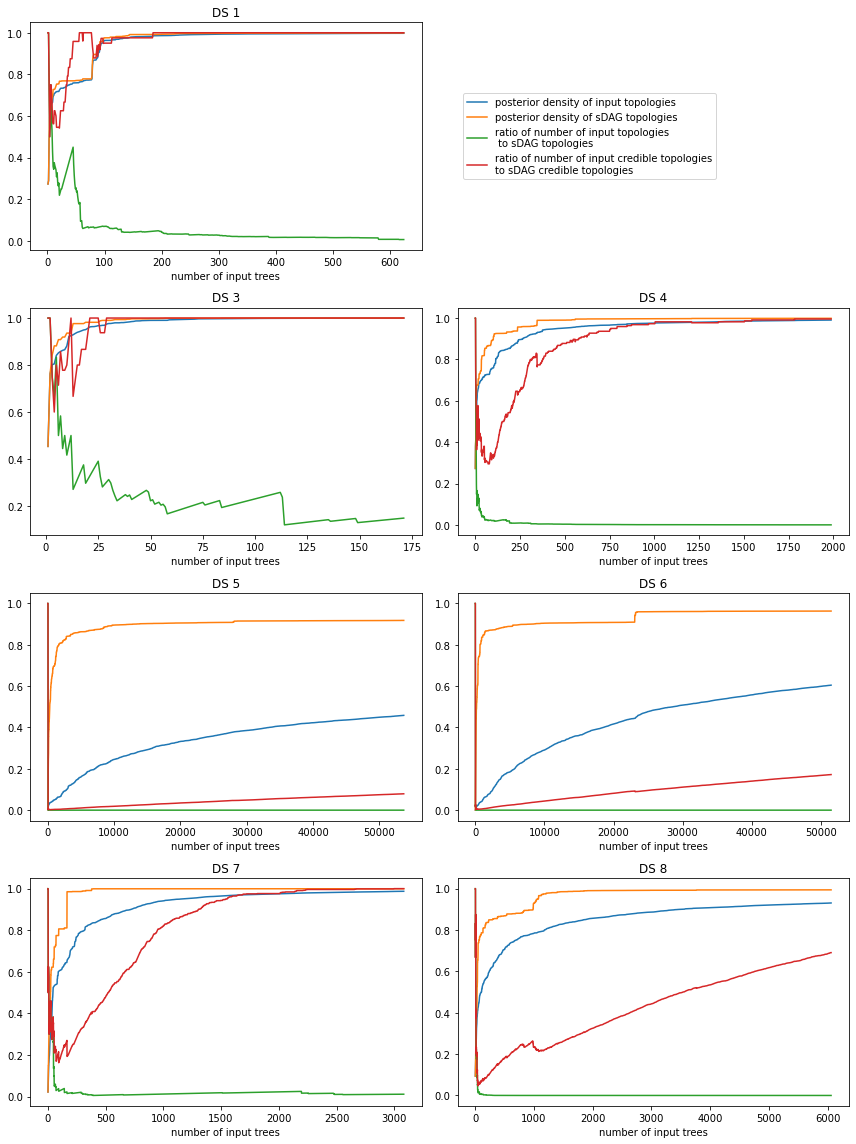

In [65]:
def plot_presearch_mcmc_data(prior="uniform"):
    """
    Create plots for density of topologies and number of topologies from short runs of Mr bayes
    and spanned sDAG.
    """
    
    ds_list = [1, 3, 4, 5, 6, 7, 8]
    the_dfs = [ds_short_mcmc_dataframes[(ds, prior)] for ds in ds_list]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    fig.set_figwidth(2*fig.get_figwidth())
    fig.set_figheight(4*fig.get_figheight())
    
    legend_axes = axes[0][1]
    axes = [axes[i][j] for i in range(4) for j in range(2) if (i,j)!=(0,1) ]
    
    for i, ds in enumerate(ds_list):
        the_df = the_dfs[i]
        ax = axes[i]
        ax.plot(the_df.support_size, the_df.total_pp)
        ax.plot(the_df.support_size, the_df.sdag_total_pp)
        ax.plot(the_df.support_size, the_df.support_size/the_df.sdag_topos_total)
        ax.plot(the_df.support_size, the_df.credible_set_found/the_df.sdag_topos_in_credible, )
        ax.set_title(f"DS {ds}")
        ax.set_xlabel("number of input trees")
    legend_axes.axis("off")
    legend_axes.plot([0], [0], label="posterior density of input topologies")
    legend_axes.plot([0], [0], label="posterior density of sDAG topologies")
    legend_axes.plot([0], [0], label="ratio of number of input topologies\n to sDAG topologies")
    legend_axes.plot([0], [0], label="ratio of number of input credible topologies\nto sDAG credible topologies")
    legend_axes.legend(loc="center left")
    fig.tight_layout()
    plt.show()
    
plot_presearch_mcmc_data("uniform")    

## plots for subsplit dag article

In [66]:
def plot_posterior_densities(ds, prior, search):
    """
    Create plots for cumulative density.

    Parameters:
        ds (int): The dataset number. This should be 1, 3, 4, 5, 6, 7, or 8.
        prior (str): The branch length prior for the Mr. Bayes posterior. This should be 
            "uniform" or "exponential".
        search (str): The search type. This should be "top-pruning" or 
            "generalized-pruning".
    """
    search_df = ds_search_results_dataframes[(ds, prior, search)]      
    mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
    mcmc_time_df = ds_short_mcmc_dataframes[(ds, prior, "time")]

    max_posterior_iter = search_df.tree_pp.argmax()
    max_credible_iter = search_df.cred_tree_count.argmax()

    dag_label = f"{search} sDAG"
    iter_label = f"{search} iteration"
    fig_title = f"{search} search of DS{ds}"
    
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_figwidth(1.75*fig.get_figwidth())
    options = {"s":10, "alpha":0.75}
    
    ax1.scatter(search_df.iter, search_df.tree_pp, **options)
    ax1.set_xlabel(iter_label)
    ax1.set_ylabel("cumulative density of trees\n in search sDAG")
    ax1.axvline(x=max_credible_iter, linestyle="--")
    ax1.axvline(x=max_posterior_iter, linestyle="--")
    
    
    ax2.scatter(search_df.llhs_computed, search_df.tree_pp, label=dag_label, **options)
    ax2.scatter(mcmc_df.mcmc_iters, mcmc_df.total_pp, label="short run of Mr. Bayes", **options)
    ax2.scatter(mcmc_df.mcmc_iters, mcmc_df.sdag_total_pp, 
                label="sdag spanned by short run of Mr. Bayes", **options)
    ax2.set_xlabel("tree log-likelihood calculations")
    ax2.set_ylabel("cumulative density of trees")
    ax2.legend()
    
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle(fig_title, va="bottom",y=0.9)
    fig.set_facecolor("white")
    
    plt.show()

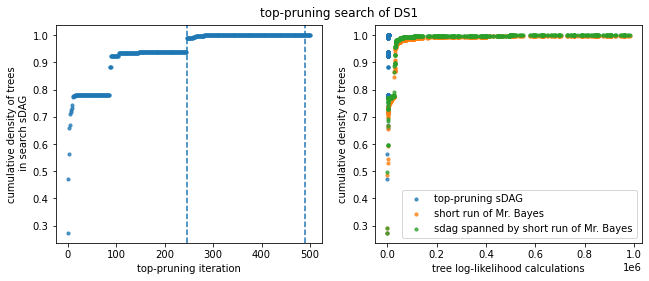

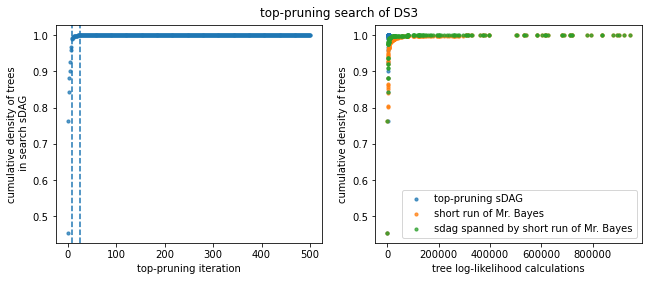

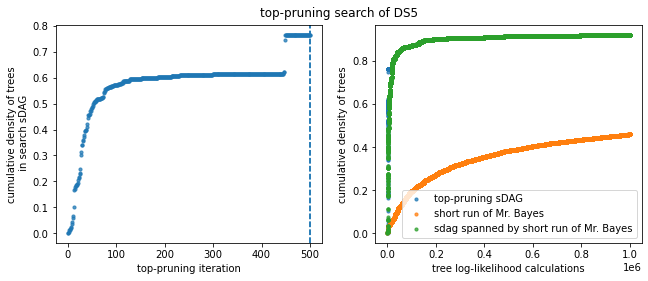

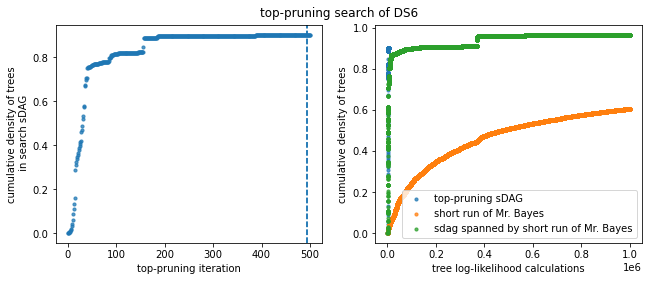

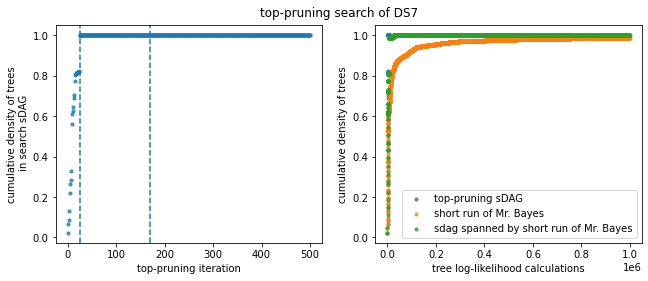

In [67]:
plot_posterior_densities(1, "uniform", "top-pruning")
plot_posterior_densities(3, "uniform", "top-pruning")
plot_posterior_densities(4, "uniform", "top-pruning")
plot_posterior_densities(5, "uniform", "top-pruning")
plot_posterior_densities(6, "uniform", "top-pruning")
plot_posterior_densities(7, "uniform", "top-pruning")
plot_posterior_densities(8, "uniform", "top-pruning")

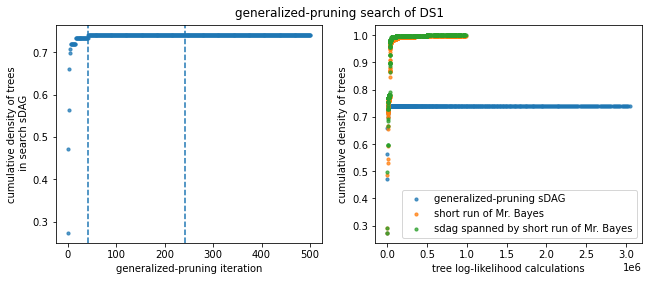

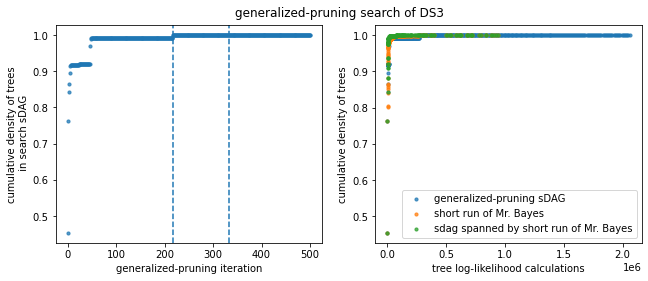

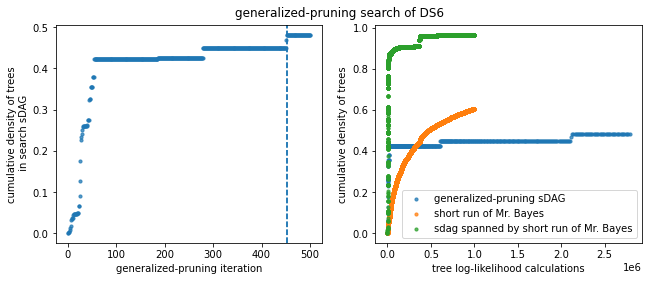

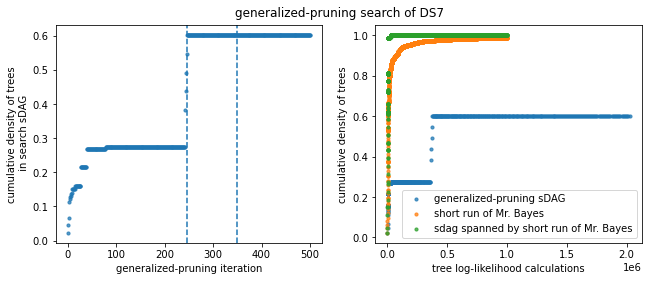

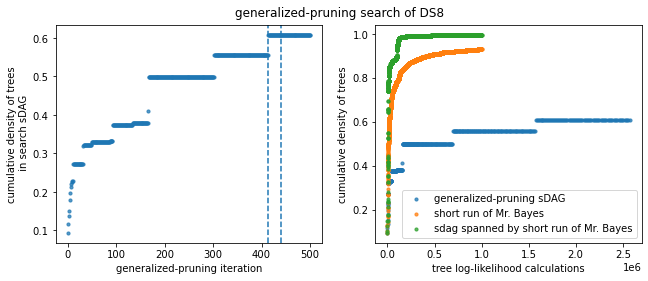

In [68]:
plot_posterior_densities(1, "uniform", "generalized-pruning")
plot_posterior_densities(3, "uniform", "generalized-pruning")
plot_posterior_densities(4, "uniform", "generalized-pruning")
plot_posterior_densities(5, "uniform", "generalized-pruning")
plot_posterior_densities(6, "uniform", "generalized-pruning")
plot_posterior_densities(7, "uniform", "generalized-pruning")
plot_posterior_densities(8, "uniform", "generalized-pruning")

In [69]:
def plot_counts(ds, prior, search):
    """
    Create plots for number of topologies and edges.

    Parameters:
        ds (int): The dataset number. This should be 1, 3, 4, 5, 6, 7, or 8.
        prior (str): The branch length prior for the Mr. Bayes posterior. This should be 
            "uniform" or "exponential".
        search (str): The search type. This should be "top-pruning" or 
            "generalized-pruning".
    """
    search_df = ds_search_results_dataframes[(ds, prior, search)]      
    mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
    mcmc_time_df = ds_short_mcmc_dataframes[(ds, prior, "time")]

    max_posterior_iter = search_df.tree_pp.argmax()
    max_credible_iter = search_df.cred_tree_count.argmax()

    
    dag_label = f"{search} sDAG"
    cred_subdag_label = "sub-sDAG spanned by found credible trees"
    posterior_subdag_label = "sub-sDAG spanned by found posterior trees"
    iter_label = f"{search} iteration"
    fig_title = f"{search} search of DS{ds}"
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_figwidth(1.75*fig.get_figwidth())
    options = {"s":10, "alpha":0.75}
     
    ax1.scatter(search_df.iter, search_df.edge_count, label=dag_label, **options)
    ax1.scatter(search_df.iter, search_df.credible_sdag_edge_count, label=cred_subdag_label, **options)
    ax1.scatter(search_df.iter, search_df.posterior_sdag_edge_count, label=posterior_subdag_label, **options)
    ax1.axvline(x=max_credible_iter, linestyle="--", c="orange")
    ax1.axvline(x=max_posterior_iter, linestyle="--", c="green")
    ax1.set_xlabel(iter_label)
    ax1.set_ylabel("edges in sDAG")
    ax1.legend()
    
    ax2.scatter(search_df.iter, search_df.tree_count.apply(int), label=dag_label, **options)
    ax2.scatter(search_df.iter, search_df.credible_sdag_tree_count, 
        label=cred_subdag_label, **options)
    ax2.scatter(search_df.iter, search_df.posterior_sdag_tree_count, 
        label=posterior_subdag_label, **options)
    ax2.axvline(x=max_credible_iter, linestyle="--", c="orange")
    ax2.axvline(x=max_posterior_iter, linestyle="--", c="green")
    ax2.set_xlabel(iter_label)
    ax2.set_ylabel("topologies in sDAG")
    ax2.set_yscale("log")
    
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle(fig_title, va="bottom",y=0.9)
    fig.set_facecolor("white")
    
    plt.show()

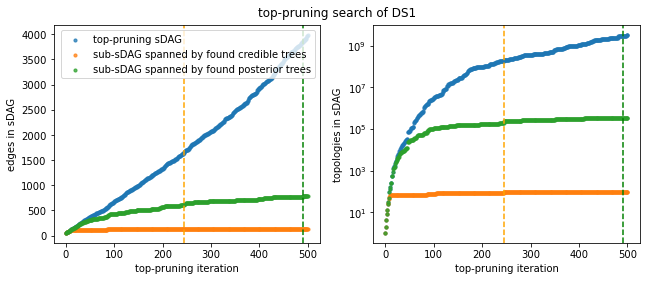

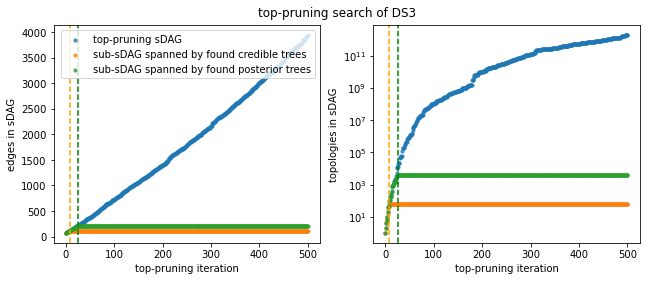

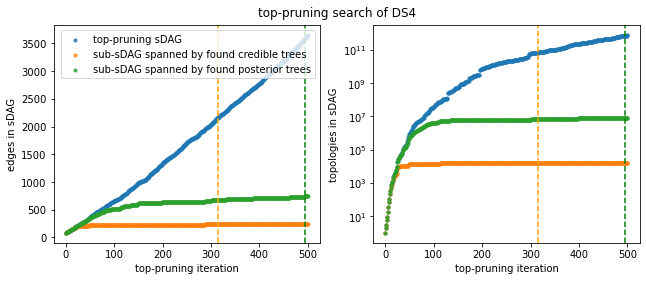

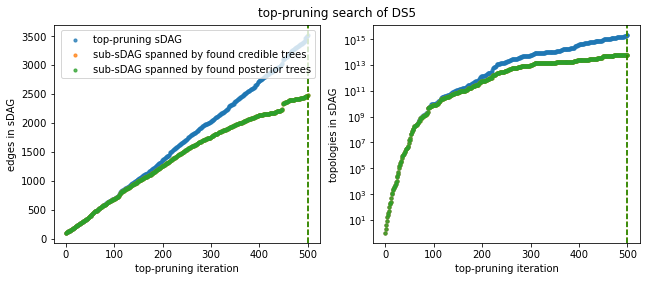

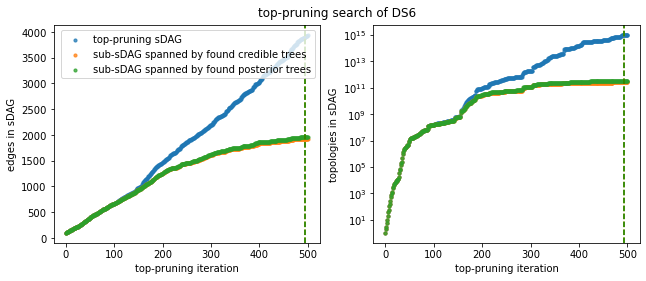

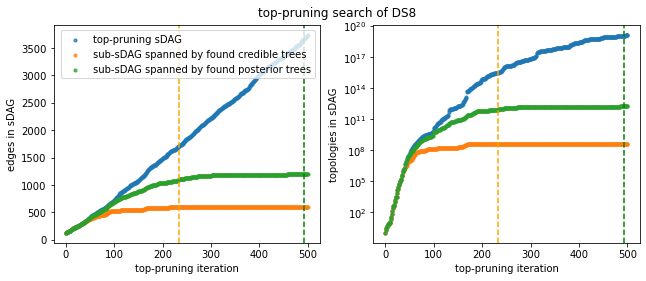

In [70]:
plot_counts(1, "uniform", "top-pruning")
plot_counts(3, "uniform", "top-pruning")
plot_counts(4, "uniform", "top-pruning")
plot_counts(5, "uniform", "top-pruning")
plot_counts(6, "uniform", "top-pruning")
plot_counts(7, "uniform", "top-pruning")
plot_counts(8, "uniform", "top-pruning")

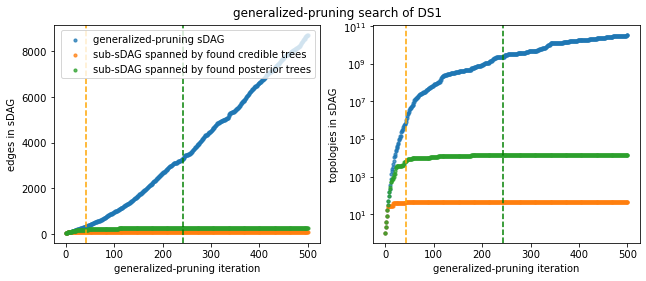

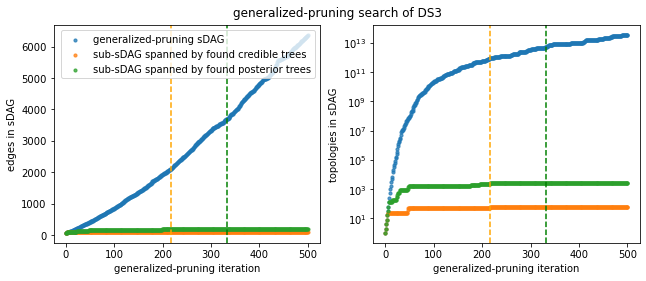

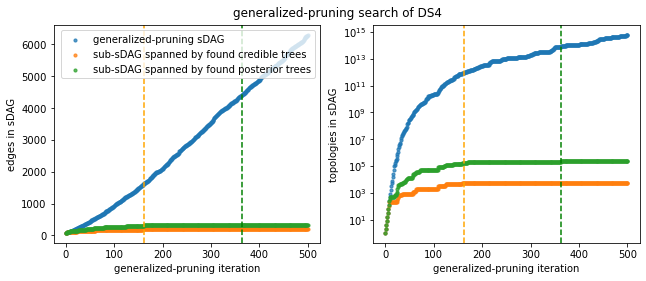

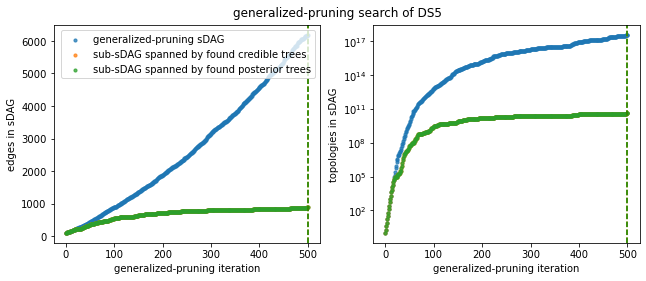

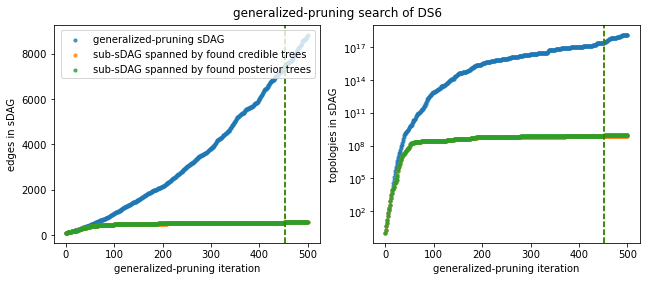

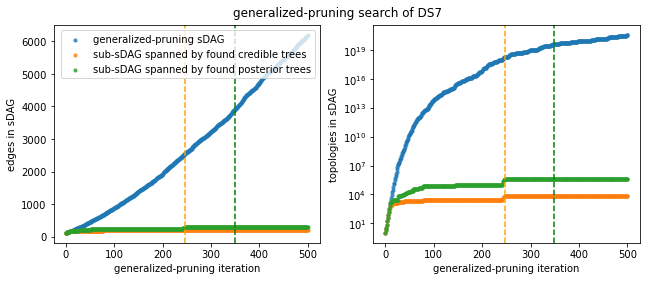

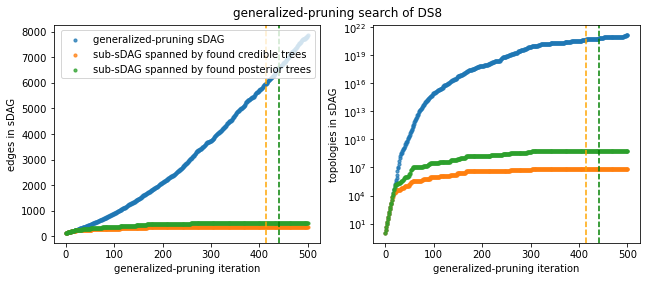

In [71]:
plot_counts(1, "uniform", "generalized-pruning")
plot_counts(3, "uniform", "generalized-pruning")
plot_counts(4, "uniform", "generalized-pruning")
plot_counts(5, "uniform", "generalized-pruning")
plot_counts(6, "uniform", "generalized-pruning")
plot_counts(7, "uniform", "generalized-pruning")
plot_counts(8, "uniform", "generalized-pruning")

In [72]:
def plot_counts_with_short_mcmc(ds, prior, search):
    """
    Create additional plots for the number of topologies and edges.
    
    Parameters:
        ds (int): The dataset number. This should be 1, 3, 4, 5, 6, 7, or 8.
        prior (str): The branch length prior for the Mr. Bayes posterior. This should be 
        "uniform" or "exponential".
        search (str): The search type. This should be "top-pruning" or 
            "generalized-pruning".
    """
    search_df = ds_search_results_dataframes[(ds, prior, search)]      
    mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
    
    dag_label = f"{search} sDAG"
    mcmc_label = "sDAG spanned by short run of Mr. Bayes"
    fig_title = f"{search} search of DS{ds}"
    
    fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
    fig.set_figwidth(2*fig.get_figwidth())
    fig.set_figheight(2*fig.get_figheight())
    options = {"s":10, "alpha":0.75}
     
    ax1.scatter(search_df.llhs_computed, search_df.edge_count, label=dag_label, **options)
    ax1.scatter(mcmc_df.mcmc_iters, mcmc_df.sdag_edge_count, label=mcmc_label, **options)
    ax1.set_xlabel("tree log-likelihood calculations")
    ax1.set_ylabel("edges in sDAG")
    ax1.legend()

    ax2.scatter(search_df.llhs_computed, search_df.tree_count.apply(int), label=dag_label, **options)
    ax2.scatter(mcmc_df.mcmc_iters, mcmc_df.sdag_topos_total, label=mcmc_label, **options)
    ax2.set_xlabel("tree log-likelihood calculations")
    ax2.set_ylabel("topologies in sDAG")
    ax2.set_yscale("log")    
    ax2.legend()
    
    ax3.scatter(search_df.tree_pp, search_df.edge_count, label=dag_label, **options)
    ax3.scatter(mcmc_df.sdag_total_pp, mcmc_df.sdag_edge_count, label=mcmc_label, **options)
    ax3.set_xlabel("cumulative density of trees")
    ax3.set_ylabel("edges in sDAG")
    ax3.legend()
    
    ax4.scatter(search_df.tree_pp, search_df.tree_count.apply(int), label=dag_label, **options)
    ax4.scatter(mcmc_df.sdag_total_pp, mcmc_df.sdag_topos_total, label=mcmc_label, **options)
    ax4.set_xlabel("cumulative density of trees")
    ax4.set_ylabel("topologies in sDAG")
    ax4.set_yscale("log")    
    ax4.legend()
    
        
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle(fig_title, va="bottom",y=0.9)
    fig.set_facecolor("white")
    
    plt.show()

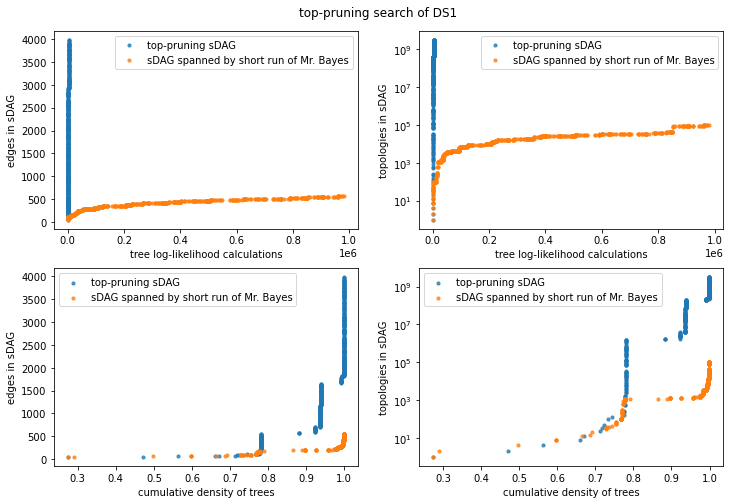

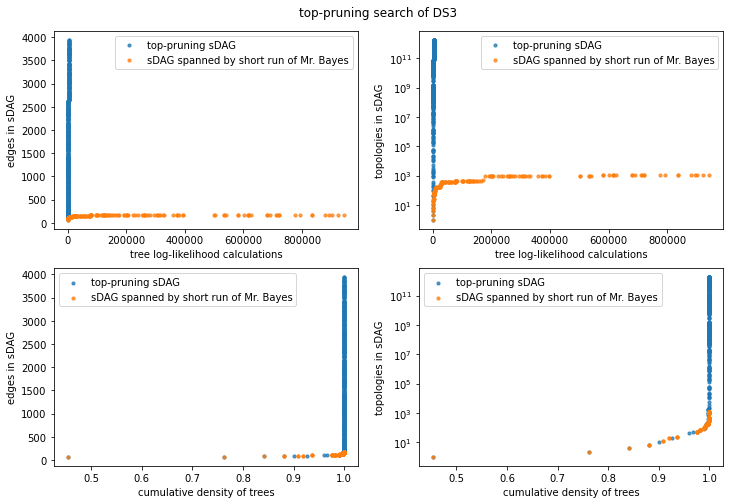

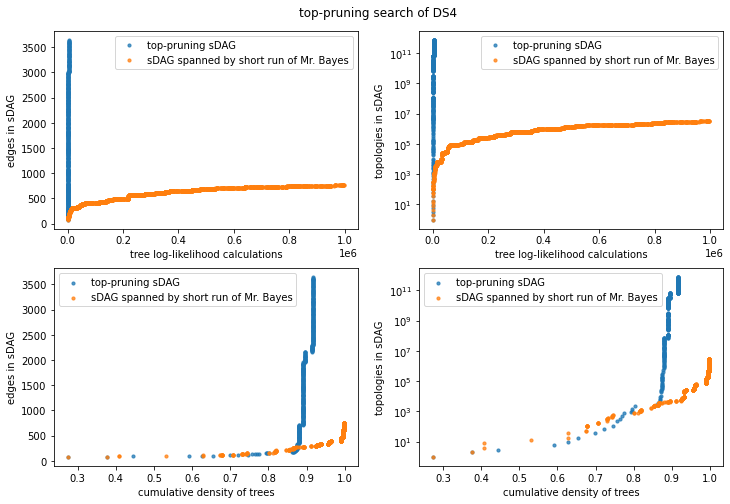

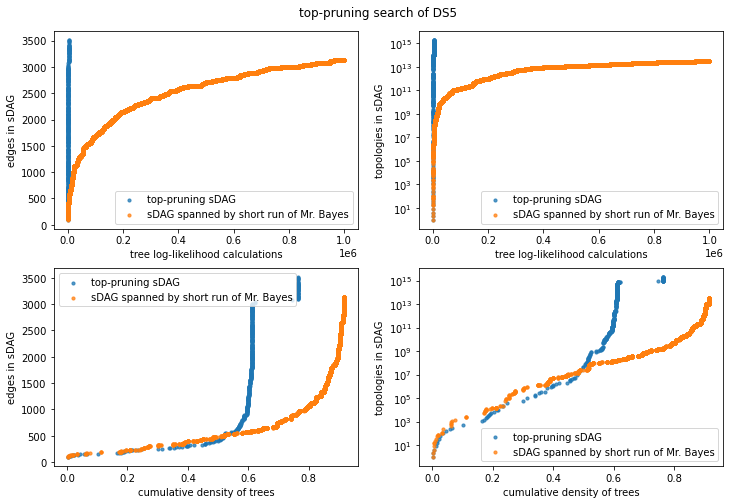

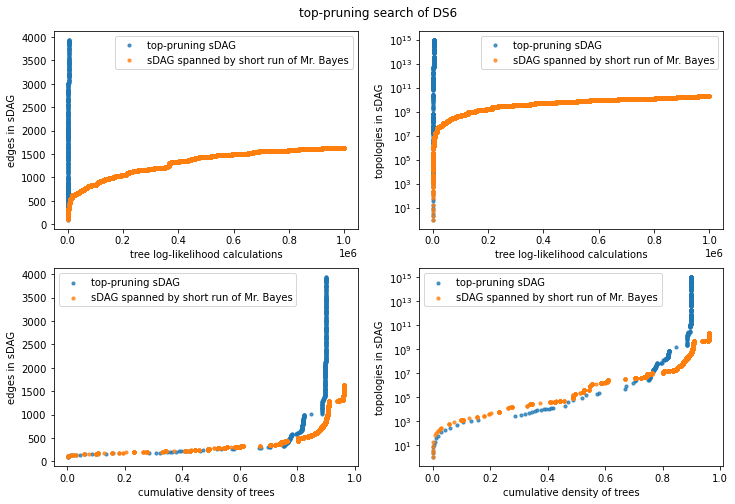

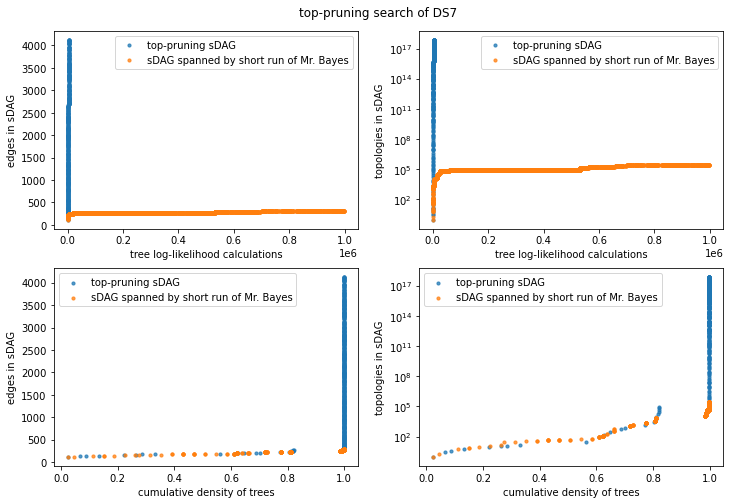

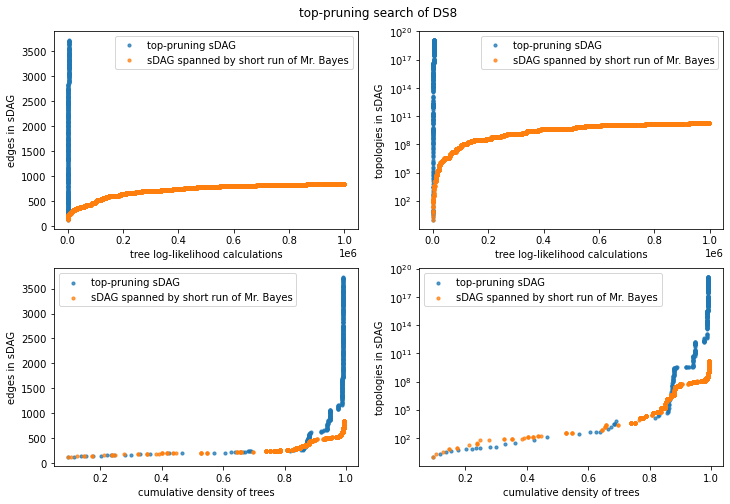

In [73]:
plot_counts_with_short_mcmc(1, "uniform", "top-pruning")
plot_counts_with_short_mcmc(3, "uniform", "top-pruning")
plot_counts_with_short_mcmc(4, "uniform", "top-pruning")
plot_counts_with_short_mcmc(5, "uniform", "top-pruning")
plot_counts_with_short_mcmc(6, "uniform", "top-pruning")
plot_counts_with_short_mcmc(7, "uniform", "top-pruning")
plot_counts_with_short_mcmc(8, "uniform", "top-pruning")


In [74]:
def plot_sdag_credibility(ds, prior, search, by_edge=True, by_cred=True):
    """
    Create plots for ratios relative credible/posterior edges/subsplits of
    a search and comparison with Mr. Bayes.

    Parameters:
        ds (int): The dataset number. This should be 1, 3, 4, 5, 6, 7, or 8.
        prior (str): The branch length prior for the Mr. Bayes posterior. This should be 
        "uniform" or "exponential".
        search (str): The search type. This should be "top-pruning" or 
            "generalized-pruning".
        by_edge (bool): When True, the counts are for sDAG edges. Otherwise the counts
            are for sDAG nodes or subsplits.
        by_cred (bool): When True, the counts are for edges/subsplits in
            topologies of the credible set. Otherwise the counts are from all topologies
            of the empirical posterior density.

    """
    search_df = ds_search_results_dataframes[(ds, prior, search)]      
    mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
    _, post_edge_count, cred_edge_count = [*posterior_edge_stats_dict[(ds,prior)].values()]
    post_subsplit_count, cred_subsplit_count = [*posterior_subsplit_stats_dict[(ds,prior)].values()]
        
    search_col, search_total, mcmc_col, mcmc_total, total_count = {
        (True, True): ("cred_edge_count", "edge_count", "sdag_edges_in_credible",
            "sdag_edge_count", cred_edge_count),
        (False, True): ("posterior_edge_count", "edge_count", "sdag_edges_in_posterior",
            "sdag_edge_count", post_edge_count),
        (True, False): ("cred_node_count", "node_count", "sdag_nodes_in_credible", 
            "sdag_node_count", cred_subsplit_count),
        (False, False): ("posterior_node_count", "node_count", "sdag_nodes_in_posterior", 
            "sdag_node_count", post_subsplit_count)
    }[(by_cred, by_edge)]
    cred_or_post = "credible" if by_cred else "in posterior"
    x_label = "edges" if by_edge else "subsplits"
      
    search_cutoff = 1 + search_df[search_col].argmax()
    mcmc_cutoff = 1 + mcmc_df[mcmc_col].argmax()        
    search_df = search_df.loc[:search_cutoff]
    mcmc_df = mcmc_df.loc[:mcmc_cutoff]

    dag_label = f"{search} sDAG"
    mcmc_label = "short-mcmc sDAG"
    fig_title = f"{search} search of DS{ds}"
        
    fig, ax = plt.subplots()
    fig.set_figwidth(2*fig.get_figwidth())
    options = {"s":5}
           
    ax.scatter(search_df[search_total], search_df[search_col] / total_count,
        label=f"fraction of all {cred_or_post} {x_label} in {dag_label}", **options)
    ax.scatter(mcmc_df[mcmc_total], mcmc_df[mcmc_col] / total_count,
        label=f"fraction of all {cred_or_post} {x_label} in {mcmc_label}", **options)
    ax.scatter(search_df[search_total], search_df[search_col] / search_df[search_total],
        label=f"fraction of {dag_label} {x_label} that are {cred_or_post}", **options)    
    ax.scatter(mcmc_df[mcmc_total], mcmc_df[mcmc_col] / mcmc_df[mcmc_total],
        label=f"fraction of {mcmc_label} {x_label} that are {cred_or_post}", **options)
    ax.set_xlabel(f"{x_label} in sDAG")
    ax.legend()
    
    
    fig.suptitle(fig_title, va="bottom",y=0.9)
    fig.set_facecolor("white")
    
    plt.show()

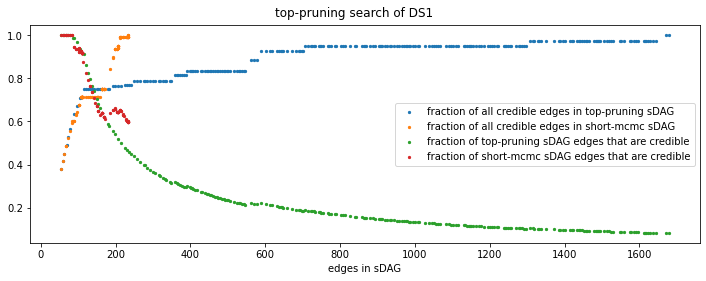

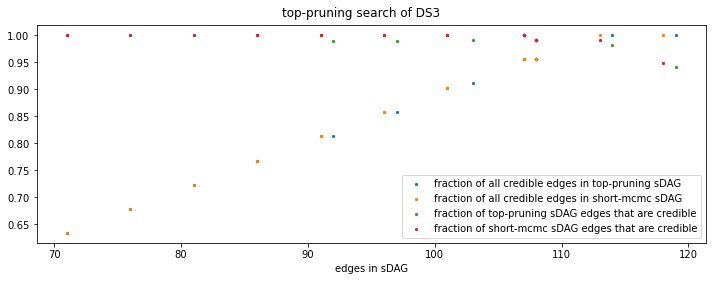

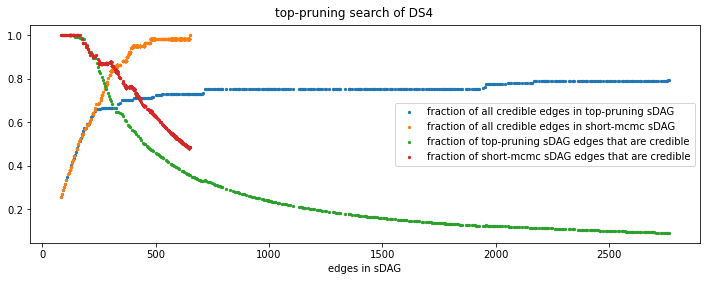

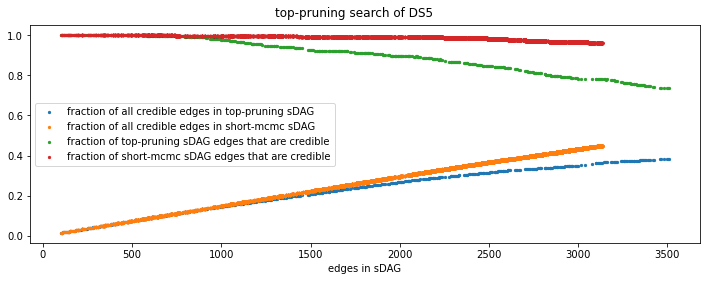

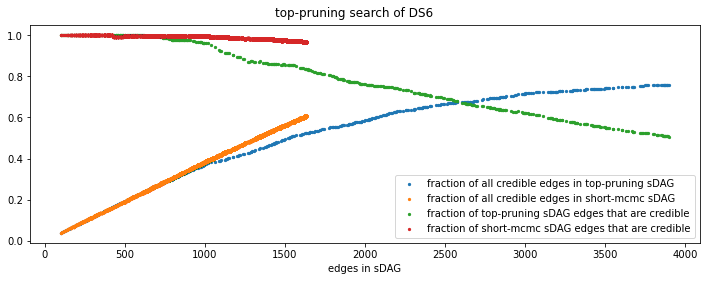

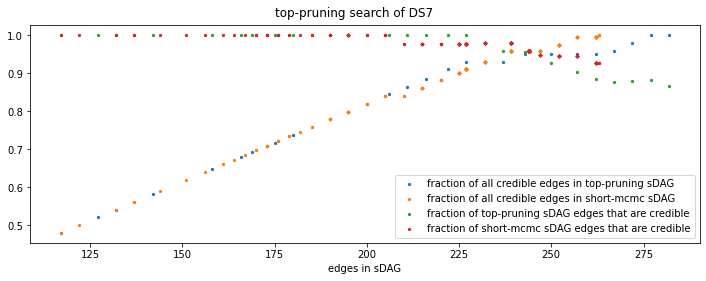

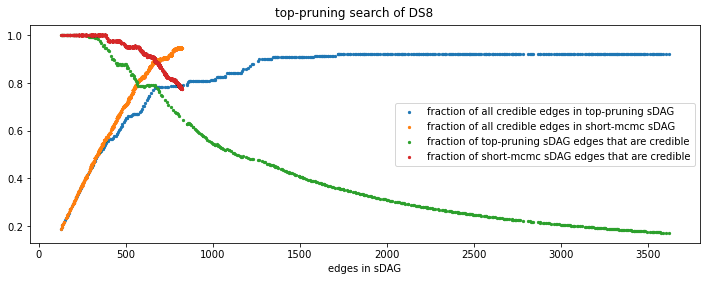

In [75]:
plot_sdag_credibility(1, "uniform", "top-pruning", True, True)
plot_sdag_credibility(3, "uniform", "top-pruning", True, True)
plot_sdag_credibility(4, "uniform", "top-pruning", True, True)
plot_sdag_credibility(5, "uniform", "top-pruning", True, True)
plot_sdag_credibility(6, "uniform", "top-pruning", True, True)
plot_sdag_credibility(7, "uniform", "top-pruning", True, True)
plot_sdag_credibility(8, "uniform", "top-pruning", True, True)

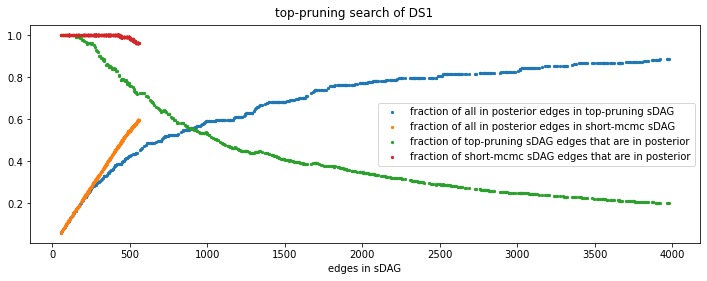

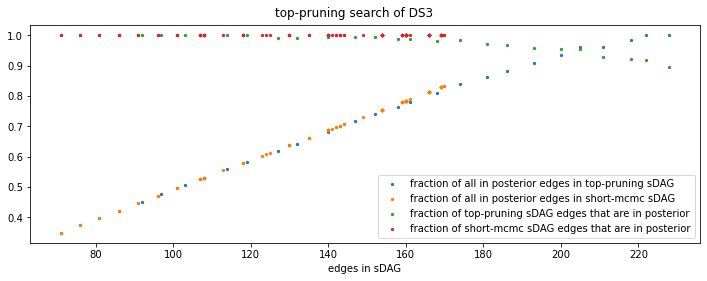

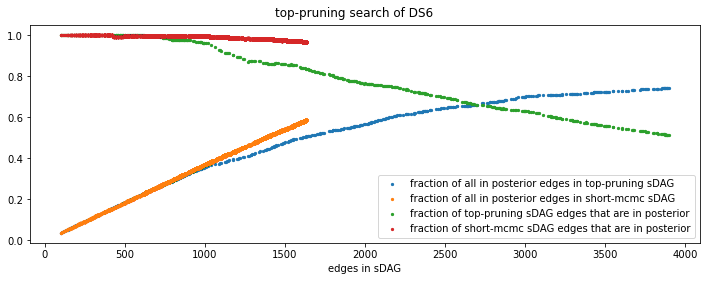

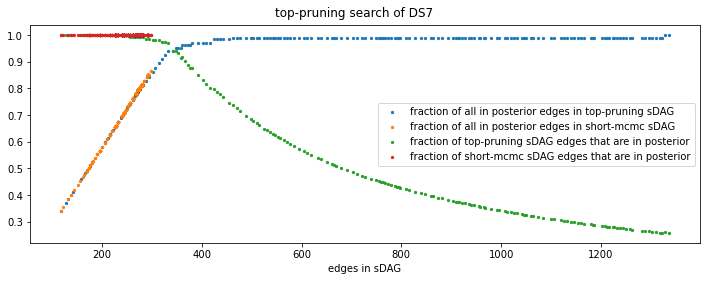

In [77]:
plot_sdag_credibility(1, "uniform", "top-pruning", True, False)
plot_sdag_credibility(3, "uniform", "top-pruning", True, False)
plot_sdag_credibility(4, "uniform", "top-pruning", True, False)
plot_sdag_credibility(5, "uniform", "top-pruning", True, False)
plot_sdag_credibility(6, "uniform", "top-pruning", True, False)
plot_sdag_credibility(7, "uniform", "top-pruning", True, False)
plot_sdag_credibility(8, "uniform", "top-pruning", True, False)

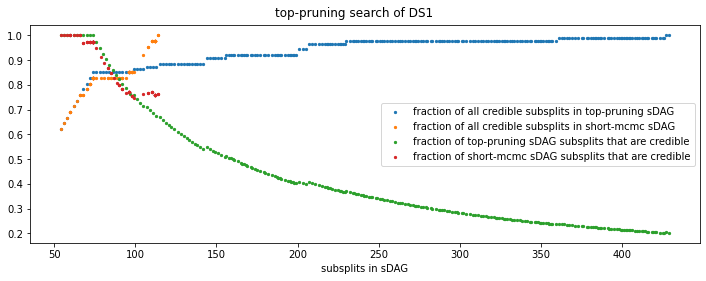

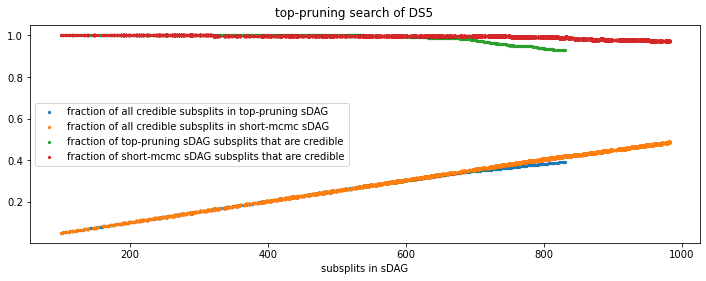

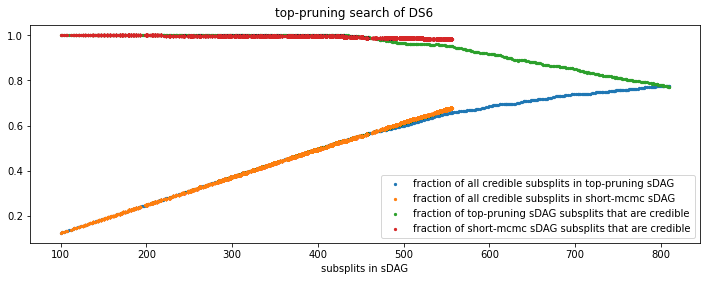

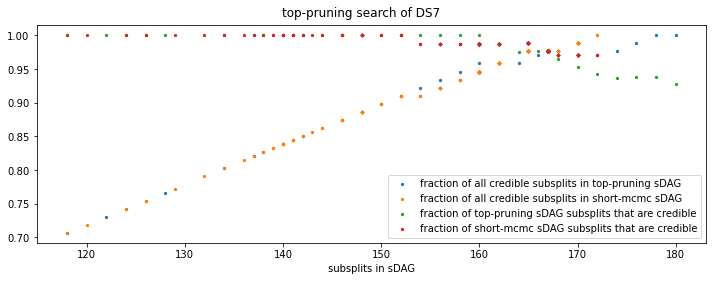

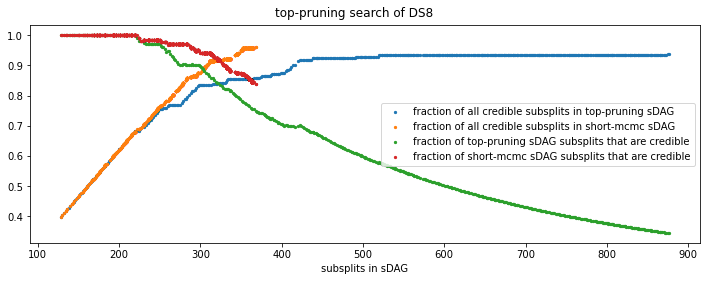

In [78]:
plot_sdag_credibility(1, "uniform", "top-pruning", False, True)
plot_sdag_credibility(3, "uniform", "top-pruning", False, True)
plot_sdag_credibility(4, "uniform", "top-pruning", False, True)
plot_sdag_credibility(5, "uniform", "top-pruning", False, True)
plot_sdag_credibility(6, "uniform", "top-pruning", False, True)
plot_sdag_credibility(7, "uniform", "top-pruning", False, True)
plot_sdag_credibility(8, "uniform", "top-pruning", False, True)

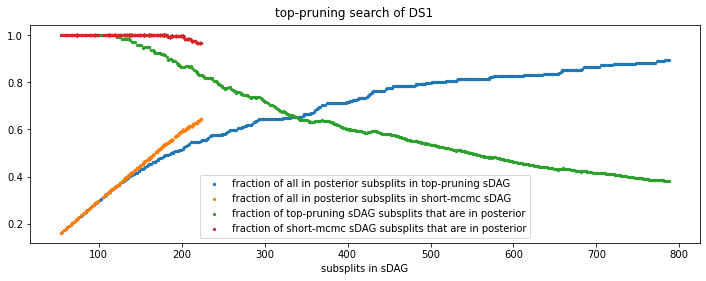

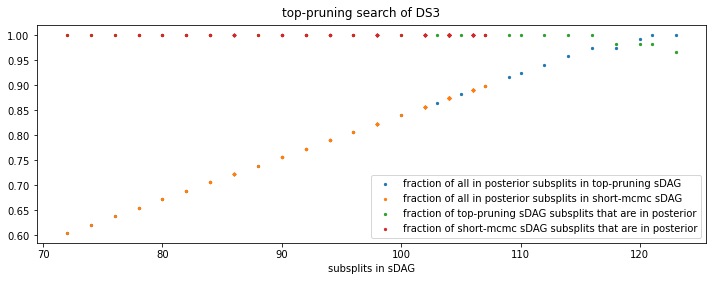

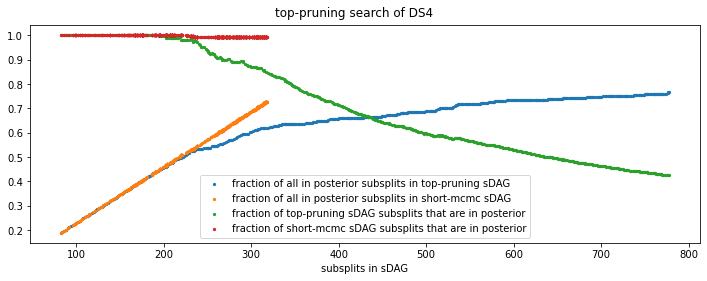

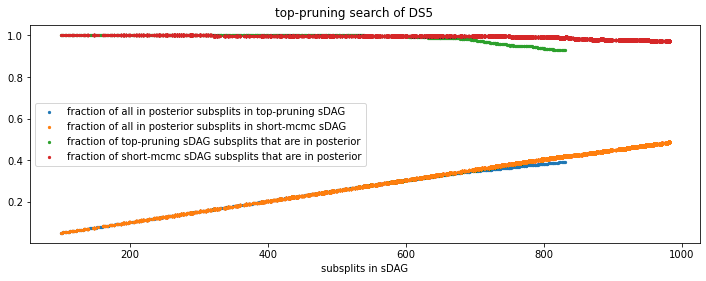

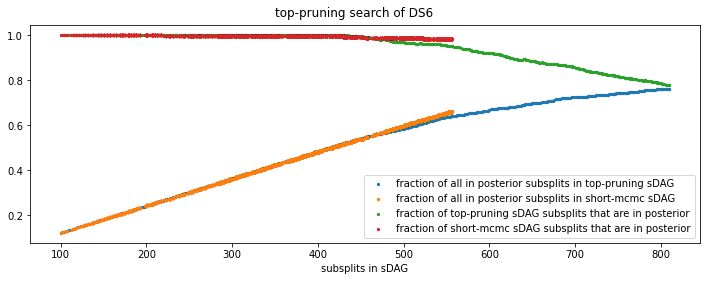

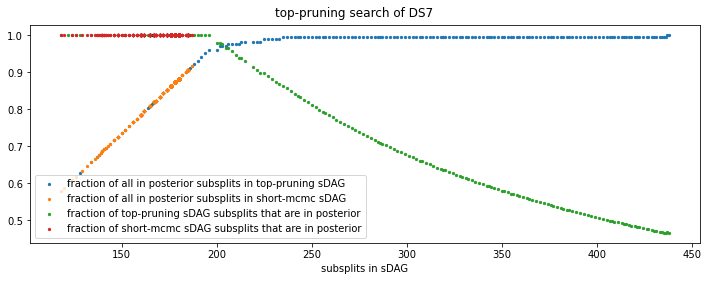

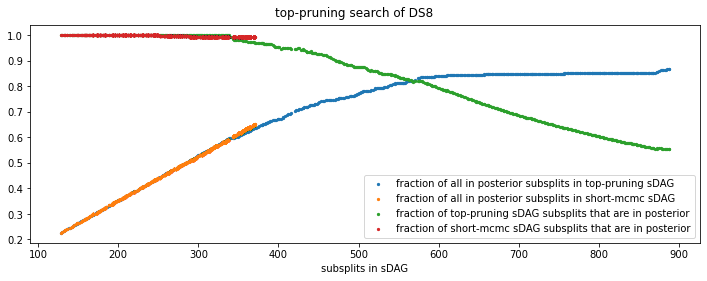

In [79]:
plot_sdag_credibility(1, "uniform", "top-pruning", False, False)
plot_sdag_credibility(3, "uniform", "top-pruning", False, False)
plot_sdag_credibility(4, "uniform", "top-pruning", False, False)
plot_sdag_credibility(5, "uniform", "top-pruning", False, False)
plot_sdag_credibility(6, "uniform", "top-pruning", False, False)
plot_sdag_credibility(7, "uniform", "top-pruning", False, False)
plot_sdag_credibility(8, "uniform", "top-pruning", False, False)